<a href="https://colab.research.google.com/github/b-akash-krishna/trance-project/blob/main/trance_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def create_project_structure():
    """Create the complete TRANCE project directory structure"""

    # Define project structure
    directories = [
        'data/raw',
        'data/processed',
        'data/embeddings',
        'notebooks',
        'src/data_processing',
        'src/models',
        'src/evaluation',
        'src/dashboard',
        'configs',
        'outputs/models',
        'outputs/figures',
        'outputs/results',
        'docs',
        'tests'
    ]

    # Create directories
    for directory in directories:
        Path(directory).mkdir(parents=True, exist_ok=True)
        print(f"✓ Created: {directory}")

    return directories

create_project_structure()

✓ Created: data/raw
✓ Created: data/processed
✓ Created: data/embeddings
✓ Created: notebooks
✓ Created: src/data_processing
✓ Created: src/models
✓ Created: src/evaluation
✓ Created: src/dashboard
✓ Created: configs
✓ Created: outputs/models
✓ Created: outputs/figures
✓ Created: outputs/results
✓ Created: docs
✓ Created: tests


['data/raw',
 'data/processed',
 'data/embeddings',
 'notebooks',
 'src/data_processing',
 'src/models',
 'src/evaluation',
 'src/dashboard',
 'configs',
 'outputs/models',
 'outputs/figures',
 'outputs/results',
 'docs',
 'tests']

In [31]:
"""
Notebook: 01_data_download.ipynb
MIMIC-III Demo Dataset Download and Initial Exploration
"""
# Cell 1: Setup and Imports
import pandas as pd
import numpy as np
import os
from pathlib import Path
import requests
import gzip
import shutil
from tqdm import tqdm
import json

# Load config
with open('configs/config.json', 'r') as f:
    config = json.load(f)

print("✓ Imports complete")
print(f"Project: {config['project']['name']} v{config['project']['version']}")

# Cell 2: Download MIMIC-III Demo Files
"""
MIMIC-III Demo Dataset
- Publicly available (no PhysioNet credentials needed)
- Contains 100 patients
- Perfect for prototyping
"""

import requests
from tqdm import tqdm
from pathlib import Path

def download_file(url, destination):
    """Download a CSV file with progress bar and error handling"""
    try:
        response = requests.get(url, stream=True)
        if response.status_code != 200:
            print(f"⚠️ Failed to download {url} (HTTP {response.status_code})")
            return False

        total_size = int(response.headers.get('content-length', 0))
        with open(destination, 'wb') as f, tqdm(
            desc=destination.name,
            total=total_size if total_size > 0 else None,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as pbar:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))

        # Verify that file is not HTML (in case of bad URL)
        with open(destination, 'r', encoding='utf-8', errors='ignore') as f:
            start = f.read(15)
            if "<html>" in start.lower():
                print(f"⚠️ Skipping {destination.name}: HTML page instead of CSV")
                destination.unlink(missing_ok=True)
                return False

        return True

    except Exception as e:
        print(f"❌ Error downloading {url}: {e}")
        return False


# ✅ Correct PhysioNet base URL (uses /files/, not /content/)
base_url = "https://physionet.org/files/mimiciii-demo/1.4/"

# Key tables we need
tables = [
    'ADMISSIONS.csv',
    'PATIENTS.csv',
    'DIAGNOSES_ICD.csv',
    'PROCEDURES_ICD.csv',
    'PRESCRIPTIONS.csv',
    'LABEVENTS.csv',
    # 'CHARTEVENTS.csv',
    'NOTEEVENTS.csv',
    'ICUSTAYS.csv',
    'D_ICD_DIAGNOSES.csv',
    'D_ICD_PROCEDURES.csv',
    'D_LABITEMS.csv'
]

# Create data directory
data_dir = Path('data/raw')
data_dir.mkdir(parents=True, exist_ok=True)

print("⬇️ Downloading MIMIC-III Demo CSV files...\n")

for table in tables:
    url = base_url + table
    dest = data_dir / table

    if dest.exists():
        print(f"✓ {table} already exists")
        continue

    print(f"Downloading {table}...")
    success = download_file(url, dest)
    if success:
        print(f"✓ Downloaded {table}")
    else:
        print(f"❌ Failed to download {table}")

print("\n✅ All available CSV files downloaded successfully!")

# # Cell 3: Extract CSV files
# """
# Extract gzipped files
# """
# print("Extracting CSV files...")

# for table in tables:
#     gz_file = data_dir / table
#     csv_file = data_dir / table.replace('.gz', '')

#     if csv_file.exists():
#         print(f"✓ {csv_file.name} already exists")
#     else:
#         print(f"Extracting {table}...")
#         with gzip.open(gz_file, 'rb') as f_in:
#             with open(csv_file, 'wb') as f_out:
#                 shutil.copyfileobj(f_in, f_out)
#         print(f"✓ Extracted {csv_file.name}")

# print("\n✅ All files extracted!")

# Cell 4: Load and explore key tables
"""
Initial Data Exploration
"""
print("Loading key tables...")
from pathlib import Path

data_dir = Path("data/raw")  # if your notebook is in notebooks/

# Load tables
admissions = pd.read_csv(data_dir / 'ADMISSIONS.csv')
patients = pd.read_csv(data_dir / 'PATIENTS.csv')
diagnoses = pd.read_csv(data_dir / 'DIAGNOSES_ICD.csv')
notes = pd.read_csv(data_dir / 'NOTEEVENTS.csv')
labs = pd.read_csv(data_dir / 'LABEVENTS.csv')
prescriptions = pd.read_csv(data_dir / 'PRESCRIPTIONS.csv')

# Standardize column names to uppercase
admissions.columns = admissions.columns.str.upper()
patients.columns = patients.columns.str.upper()
diagnoses.columns = diagnoses.columns.str.upper()
notes.columns = notes.columns.str.upper()
labs.columns = labs.columns.str.upper()
prescriptions.columns = prescriptions.columns.str.upper()


print("✓ Tables loaded\n")

# Display table sizes
print("=" * 60)
print("MIMIC-III Demo Dataset Overview")
print("=" * 60)
print(f"Patients:        {len(patients):>10,} rows")
print(f"Admissions:      {len(admissions):>10,} rows")
print(f"Diagnoses:       {len(diagnoses):>10,} rows")
print(f"Clinical Notes:  {len(notes):>10,} rows")
print(f"Lab Events:      {len(labs):>10,} rows")
print(f"Prescriptions:   {len(prescriptions):>10,} rows")
print("=" * 60)

# Cell 5: Admissions Table Exploration
"""
Explore ADMISSIONS table - our primary table
"""
print("ADMISSIONS Table Sample:")
print(admissions.head())
print("\nColumns:", admissions.columns.tolist())
print("\nData Types:")
print(admissions.dtypes)
print("\nMissing Values:")
print(admissions.isnull().sum())

# admissions.columns = admissions.columns.str.upper()

admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])
admissions['DEATHTIME'] = pd.to_datetime(admissions['DEATHTIME'])

admissions['LOS_DAYS'] = (admissions['DISCHTIME'] - admissions['ADMITTIME']).dt.total_seconds() / 86400

print("\nAdmission Statistics:")
print(admissions[['LOS_DAYS']].describe())

# Cell 6: Patient Demographics
"""
Explore patient demographics
"""
# Merge patients with admissions for analysis
patient_admissions = admissions.merge(patients, on='SUBJECT_ID')

# Calculate age at admission
patient_admissions['AGE'] = patient_admissions['ADMITTIME'].dt.year - patient_admissions['DOB'].apply(lambda x: pd.to_datetime(x).year)

print("Patient Demographics:")
print("\nGender Distribution:")
print(patient_admissions['GENDER'].value_counts())

print("\nAge Statistics:")
print(patient_admissions['AGE'].describe())

print("\nEthnicity Distribution:")
print(patient_admissions['ETHNICITY'].value_counts().head(10))

print("\nInsurance Distribution:")
print(patient_admissions['INSURANCE'].value_counts())
import pandas as pd
import numpy as np
from pathlib import Path

data_dir = Path("data/raw")  # Adjust if your notebook is elsewhere

# Load tables
admissions = pd.read_csv(data_dir / 'ADMISSIONS.csv')
diagnoses = pd.read_csv(data_dir / 'DIAGNOSES_ICD.csv')
noteevents = pd.read_csv(data_dir / 'NOTEEVENTS.csv')
procedures = pd.read_csv(data_dir / 'PROCEDURES_ICD.csv')
patients = pd.read_csv(data_dir / 'PATIENTS.csv')
prescriptions = pd.read_csv(data_dir / 'PRESCRIPTIONS.csv')

# Capitalize column names
admissions.columns = admissions.columns.str.upper()
diagnoses.columns = diagnoses.columns.str.upper()
noteevents.columns = noteevents.columns.str.upper()
procedures.columns = procedures.columns.str.upper()
patients.columns = patients.columns.str.upper()
prescriptions.columns = prescriptions.columns.str.upper()

# Merge admissions with patient info
admissions_patients = admissions.merge(patients, on='SUBJECT_ID', suffixes=('_ADM', '_PAT'))

# Convert to datetime
admissions_patients['ADMITTIME'] = pd.to_datetime(admissions_patients['ADMITTIME'])
admissions_patients['DISCHTIME'] = pd.to_datetime(admissions_patients['DISCHTIME'])
admissions_patients['DOB'] = pd.to_datetime(admissions_patients['DOB'])

# Calculate age and LOS
admissions_patients['AGE'] = admissions_patients['ADMITTIME'].dt.year - admissions_patients['DOB'].dt.year
admissions_patients['LOS_DAYS'] = (admissions_patients['DISCHTIME'] - admissions_patients['ADMITTIME']).dt.total_seconds() / (24*3600)

# Updated discharge text generator
def generate_discharge_text_updated(hadm_id):
    row = admissions_patients[admissions_patients['HADM_ID'] == hadm_id].iloc[0]

    age = row.get('AGE', 'unknown age')
    gender = row.get('GENDER', 'unknown gender')
    if gender == 'M':
        gender = 'male'
    elif gender == 'F':
        gender = 'female'
    admit_date = row.get('ADMITTIME').strftime('%Y-%m-%d') if pd.notna(row.get('ADMITTIME')) else 'unknown date'
    los_days = round(row.get('LOS_DAYS', 0), 1)
    admission_type = row.get('ADMISSION_TYPE', 'unspecified')
    discharge_location = row.get('DISCHARGE_LOCATION', 'unknown')

    # Diagnoses
    patient_diag = diagnoses[diagnoses['HADM_ID'] == hadm_id]
    diag_text = ", ".join(patient_diag['ICD9_CODE'].astype(str).tolist()) or "No significant diagnoses recorded"

    # Procedures
    patient_proc = procedures[procedures['HADM_ID'] == hadm_id]
    proc_text = ", ".join(patient_proc['ICD9_CODE'].astype(str).tolist()) or "No procedures performed"

    # Prescriptions
    patient_rx = prescriptions[prescriptions['HADM_ID'] == hadm_id]
    rx_list = []
    for _, rx in patient_rx.iterrows():
        med = rx.get('DRUG', 'Unknown drug')
        dose = rx.get('DOSE_VAL_RX', '')
        unit = rx.get('DOSE_UNIT_RX', '')
        route = rx.get('ROUTE', '')
        parts = [str(part) for part in [dose, unit, route, med] if part]
        rx_list.append(" ".join(parts))
    rx_text = "; ".join(rx_list) if rx_list else "No medications prescribed"

    discharge_summary = (
        f"The patient is a {age}-year-old {gender} admitted on {admit_date} "
        f"via {admission_type}. During the {los_days}-day hospital stay, "
        f"the following diagnoses were recorded: {diag_text}. "
        f"Procedures performed include: {proc_text}. "
        f"At discharge, the patient was prescribed: {rx_text}. "
        f"The patient was discharged to {discharge_location} with appropriate follow-up instructions."
    )

    return discharge_summary

# Populate NOTEEVENTS
for idx, row in admissions_patients.iterrows():
    hadm_id = row['HADM_ID']

    # Find existing notes
    note_idx = noteevents[noteevents['HADM_ID'] == hadm_id].index

    if len(note_idx) == 0:
        new_row = {
            'ROW_ID': noteevents['ROW_ID'].max() + 1 if len(noteevents) > 0 else 1,
            'SUBJECT_ID': row['SUBJECT_ID'],
            'HADM_ID': hadm_id,
            'CHARTDATE': row['ADMITTIME'].strftime('%Y-%m-%d') if pd.notna(row['ADMITTIME']) else '',
            'CHARTTIME': row['ADMITTIME'].strftime('%H:%M:%S') if pd.notna(row['ADMITTIME']) else '',
            'STORETIME': row['ADMITTIME'] if pd.notna(row['ADMITTIME']) else '',
            'CATEGORY': 'Discharge summary',
            'DESCRIPTION': 'Synthetic discharge summary',
            'CGID': np.nan,
            'ISERROR': False,
            'TEXT': generate_discharge_text_updated(hadm_id)
        }
        noteevents = pd.concat([noteevents, pd.DataFrame([new_row])], ignore_index=True)
    else:
        # Update empty TEXT fields
        for i in note_idx:
            if pd.isna(noteevents.at[i, 'TEXT']) or noteevents.at[i, 'TEXT'].strip() == '':
                noteevents.at[i, 'TEXT'] = generate_discharge_text_updated(hadm_id)
                noteevents.at[i, 'CATEGORY'] = 'Discharge summary'
                noteevents.at[i, 'DESCRIPTION'] = 'Synthetic discharge summary'

# Save updated NOTEEVENTS
noteevents.to_csv(data_dir / 'NOTEEVENTS_with_discharge_text.csv', index=False)

# Preview
print(noteevents[['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CATEGORY', 'DESCRIPTION', 'TEXT']].head(2).to_string())

# Cell 7: Clinical Notes Analysis
"""
Explore clinical notes - critical for embeddings
"""
print("Clinical Notes Analysis")
print("=" * 60)

print("\nNote Categories:")
print(noteevents['CATEGORY'].value_counts())

print("\nNote Descriptions:")
print(noteevents['DESCRIPTION'].value_counts().head(10))

# Filter discharge summaries
discharge_notes = noteevents[noteevents['CATEGORY'] == 'Discharge summary']
print(f"\nDischarge Summaries: {len(discharge_notes)} notes")

# Sample discharge summary
print("\nSample Discharge Summary:")
print("=" * 60)
if len(discharge_notes) > 0:
    sample = discharge_notes.iloc[0]
    print(f"Subject ID: {sample['SUBJECT_ID']}")
    print(f"Admission ID: {sample['HADM_ID']}")
    print(f"Chart Date: {sample['CHARTDATE']}")
    print(f"\nText (first 500 chars):")
    print(sample['TEXT'][:500] if pd.notna(sample['TEXT']) else "No text available")
    print("...")
# Cell 8: Readmission Analysis
"""
Identify readmissions in demo data
"""
print("Readmission Analysis")
print("=" * 60)

# Ensure datetime
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'], errors='coerce')
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'], errors='coerce')

# Drop rows where dates are missing
admissions_clean = admissions.dropna(subset=['ADMITTIME', 'DISCHTIME'])

# Sort by patient and admission time
admissions_sorted = admissions_clean.sort_values(['SUBJECT_ID', 'ADMITTIME'])

# Calculate time to next admission
admissions_sorted['NEXT_ADMIT'] = admissions_sorted.groupby('SUBJECT_ID')['ADMITTIME'].shift(-1)
admissions_sorted['DAYS_TO_NEXT_ADMIT'] = (
    (admissions_sorted['NEXT_ADMIT'] - admissions_sorted['DISCHTIME']).dt.total_seconds() / 86400
)

# Flag 30-day readmission
admissions_sorted['TARGET_READMIT_30'] = (admissions_sorted['DAYS_TO_NEXT_ADMIT'] <= 30) & (admissions_sorted['DAYS_TO_NEXT_ADMIT'] > 0)

print(f"Total admissions: {len(admissions_sorted)}")
print(f"Patients with multiple admissions: {admissions_sorted.groupby('SUBJECT_ID').size().gt(1).sum()}")
print(f"30-day readmissions: {admissions_sorted['TARGET_READMIT_30'].sum()} ({admissions_sorted['TARGET_READMIT_30'].mean()*100:.1f}%)")


# Cell 9: Diagnosis Analysis
"""
Analyze diagnosis patterns
"""
print("Diagnosis Analysis")
print("=" * 60)

# Load diagnosis descriptions
d_icd = pd.read_csv(data_dir / 'D_ICD_DIAGNOSES.csv')
d_icd.columns = d_icd.columns.str.upper()

# Merge with diagnoses
diagnoses_with_desc = diagnoses.merge(d_icd, on=['ICD9_CODE'], how='left')

print(f"Total diagnosis records: {len(diagnoses)}")
print(f"Unique ICD9 codes: {diagnoses['ICD9_CODE'].nunique()}")

print("\nTop 10 Most Common Diagnoses:")
top_diagnoses = diagnoses_with_desc.groupby(['ICD9_CODE', 'LONG_TITLE']).size().sort_values(ascending=False).head(10)
for (code, title), count in top_diagnoses.items():
    print(f"{code:>6} | {count:>3} | {title}")


✓ Imports complete
Project: TRANCE v1.0.0
⬇️ Downloading MIMIC-III Demo CSV files...

✓ ADMISSIONS.csv already exists
✓ PATIENTS.csv already exists
✓ DIAGNOSES_ICD.csv already exists
✓ PROCEDURES_ICD.csv already exists
✓ PRESCRIPTIONS.csv already exists
✓ LABEVENTS.csv already exists
✓ NOTEEVENTS.csv already exists
✓ ICUSTAYS.csv already exists
✓ D_ICD_DIAGNOSES.csv already exists
✓ D_ICD_PROCEDURES.csv already exists
✓ D_LABITEMS.csv already exists

✅ All available CSV files downloaded successfully!
Loading key tables...
✓ Tables loaded

MIMIC-III Demo Dataset Overview
Patients:               100 rows
Admissions:             129 rows
Diagnoses:            1,761 rows
Clinical Notes:           0 rows
Lab Events:          76,074 rows
Prescriptions:       10,398 rows
ADMISSIONS Table Sample:
   ROW_ID  SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
0   12258       10006   142345  2164-10-23 21:09:00  2164-11-01 17:15:00   
1   12263       10011   105331  2126-08-14 22:32

✓ Setup complete
Loading data tables...
✓ Loaded 129 admissions
✓ Loaded 100 patients
✓ Loaded 129 clinical notes
Calculating admission features...
✓ Features calculated
Age range: 17.0 - 120.0 years
LOS range: 0.0 - 124.0 days

APPLYING INCLUSION CRITERIA

Initial admissions: 129
After age >= 18: 128 (99.2%)
After LOS >= 24h: 118 (91.5%)
After non-elective: 110 (85.3%)
After has discharge: 110 (85.3%)

✓ Eligible admissions after inclusion: 110

APPLYING EXCLUSION CRITERIA
Excluded in-hospital deaths: 31
Remaining: 79 (71.8%)

✓ Final cohort after exclusions: 79

CREATING READMISSION LABELS
Readmission window: 30 days
Total admissions in cohort: 79
30-day readmissions: 6
Readmission rate: 7.59%

Last admissions per patient (censored): 58
Evaluable admissions: 21

CHECKING DISCHARGE SUMMARY AVAILABILITY
Total discharge summaries in database: 129
Admissions with discharge summaries: 79/79 (100.0%)

✓ Good discharge summary coverage

Proceeding with all 79 admissions
(Admissions without 

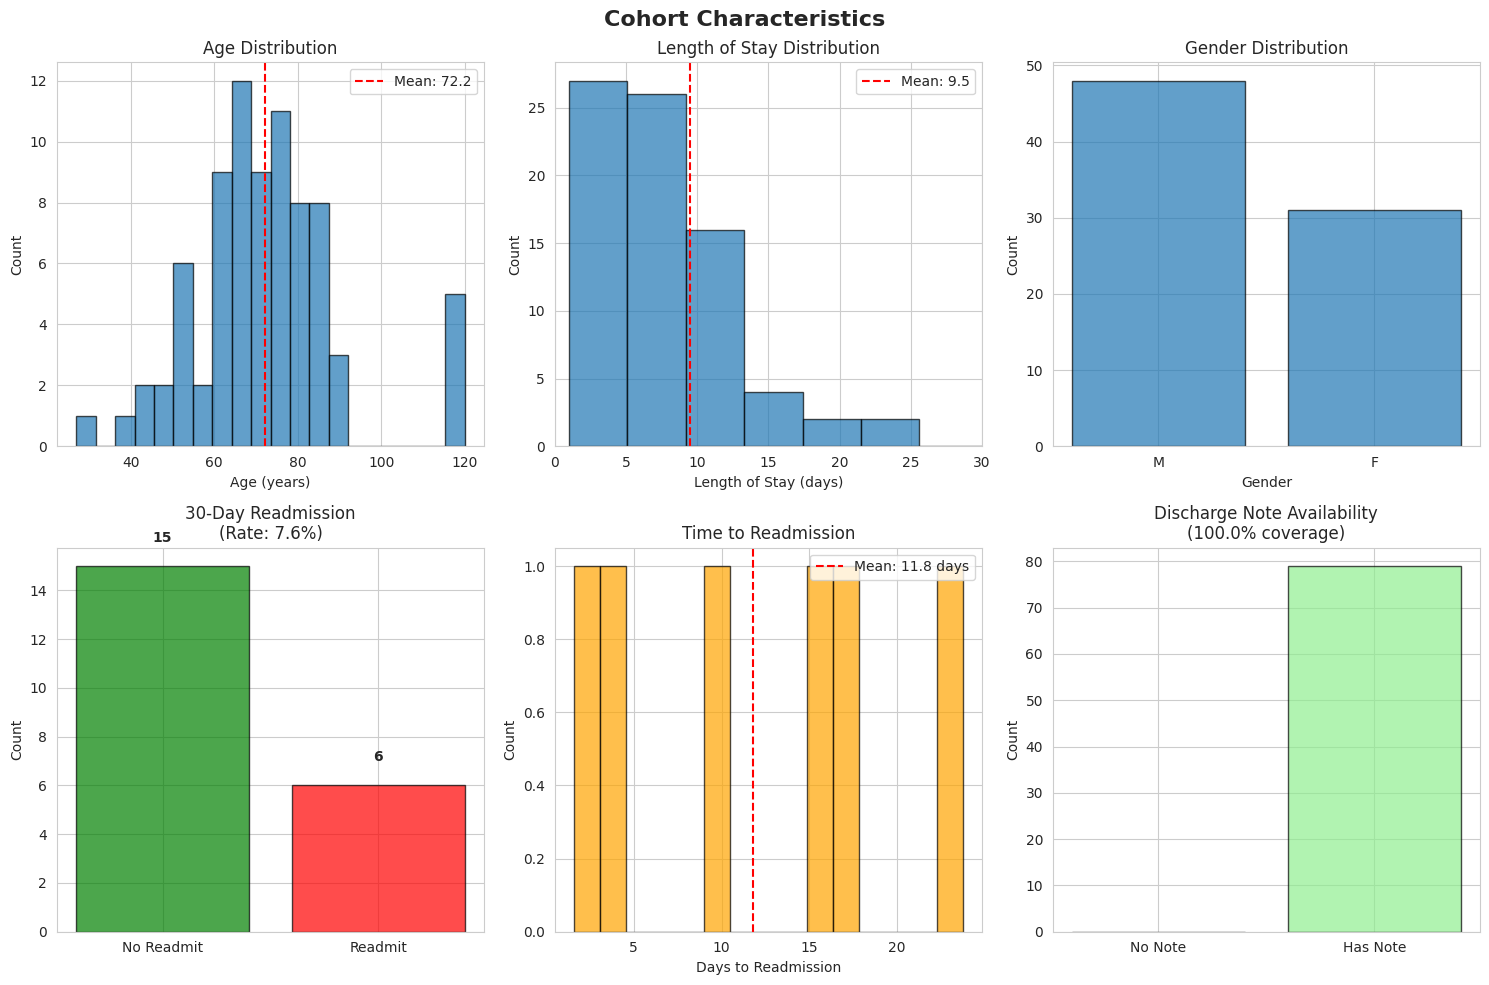


SAVING COHORT DATASET
✓ Saved cohort to: data/processed/cohort_with_outcomes.parquet
   Shape: (79, 20)
   Size: 71.1 KB
✓ Also saved as CSV: data/processed/cohort_with_outcomes.csv

✓ Summary report saved to: outputs/results/cohort_summary.json

COHORT DEFINITION COMPLETE!

✅ Final cohort: 79 admissions
✅ Readmission rate: 7.59%
✅ Discharge note coverage: 100.0%

📊 Outputs saved:
   - Cohort data: data/processed/cohort_with_outcomes.parquet
   - Visualization: outputs/figures/cohort_characteristics.png
   - Summary: outputs/results/cohort_summary.json

📝 Next Steps:
   1. Review cohort characteristics above
   2. Proceed to notebook 03_feature_engineering.ipynb
   3. Extract structured features for modeling


In [8]:
"""
Notebook: 02_cohort_definition.ipynb
Define study cohort with inclusion/exclusion criteria and create readmission labels
"""

# Cell 1: Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import timedelta

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

# Load config
with open('configs/config.json', 'r') as f:
    config = json.load(f)

data_dir = Path('data/raw')
print("✓ Setup complete")

# Cell 2: Load Core Tables
"""
Load the essential tables for cohort definition
"""
print("Loading data tables...")

admissions = pd.read_csv(data_dir / 'ADMISSIONS.csv')
patients = pd.read_csv(data_dir / 'PATIENTS.csv')
notes = pd.read_csv(data_dir / 'NOTEEVENTS_with_discharge_text.csv')

# Standardize column names to uppercase
admissions.columns = admissions.columns.str.upper()
patients.columns = patients.columns.str.upper()
notes.columns = notes.columns.str.upper()

# Convert date columns
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])
admissions['DEATHTIME'] = pd.to_datetime(admissions['DEATHTIME'])
admissions['EDREGTIME'] = pd.to_datetime(admissions['EDREGTIME'])
admissions['EDOUTTIME'] = pd.to_datetime(admissions['EDOUTTIME'])

patients['DOB'] = pd.to_datetime(patients['DOB'])
patients['DOD'] = pd.to_datetime(patients['DOD'])

print(f"✓ Loaded {len(admissions)} admissions")
print(f"✓ Loaded {len(patients)} patients")
print(f"✓ Loaded {len(notes)} clinical notes")

# Cell 3: Calculate Basic Features
"""
Add essential calculated fields
"""
print("Calculating admission features...")

# Ensure all columns are uppercase
admissions.columns = admissions.columns.str.upper()
patients.columns = patients.columns.str.upper()

# Merge patient info (DOB, DOD, GENDER)
admissions = admissions.merge(
    patients[['SUBJECT_ID', 'DOB', 'DOD', 'GENDER']],
    on='SUBJECT_ID',
    how='left'
)

# Convert datetime columns safely
for col in ['ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'DOB']:
    admissions[col] = pd.to_datetime(admissions[col], errors='coerce')

# Calculate length of stay in days
admissions['LOS_DAYS'] = (admissions['DISCHTIME'] - admissions['ADMITTIME']).dt.total_seconds() / 86400

# Calculate age at admission safely
admissions['AGE'] = admissions['ADMITTIME'].dt.year - admissions['DOB'].dt.year
admissions['AGE'] -= ((admissions['ADMITTIME'].dt.month < admissions['DOB'].dt.month) |
                      ((admissions['ADMITTIME'].dt.month == admissions['DOB'].dt.month) &
                       (admissions['ADMITTIME'].dt.day < admissions['DOB'].dt.day)))
admissions['AGE'] = admissions['AGE'].clip(0, 120)  # clip unrealistic ages

# In-hospital mortality flag
admissions['HOSPITAL_MORTALITY'] = admissions['HOSPITAL_EXPIRE_FLAG'] == 1

# Summary
print("✓ Features calculated")
print(f"Age range: {admissions['AGE'].min():.1f} - {admissions['AGE'].max():.1f} years")
print(f"LOS range: {admissions['LOS_DAYS'].min():.1f} - {admissions['LOS_DAYS'].max():.1f} days")

# Cell 4: Inclusion Criteria
"""
Apply inclusion criteria to define eligible admissions
"""
print("\n" + "="*60)
print("APPLYING INCLUSION CRITERIA")
print("="*60)

# Start with all admissions
cohort = admissions.copy()
initial_count = len(cohort)
print(f"\nInitial admissions: {initial_count}")

# Criterion 1: Adult patients (Age >= 18)
min_age = config['data']['cohort']['min_age']
cohort = cohort[cohort['AGE'] >= min_age]
print(f"After age >= {min_age}: {len(cohort)} ({len(cohort)/initial_count*100:.1f}%)")

# Criterion 2: Minimum length of stay (>= 24 hours)
min_los_hours = config['data']['cohort']['min_los_hours']
min_los_days = min_los_hours / 24
cohort = cohort[cohort['LOS_DAYS'] >= min_los_days]
print(f"After LOS >= {min_los_hours}h: {len(cohort)} ({len(cohort)/initial_count*100:.1f}%)")

# Criterion 3: Non-elective admissions (emergency or urgent)
cohort = cohort[cohort['ADMISSION_TYPE'].isin(['EMERGENCY', 'URGENT'])]
print(f"After non-elective: {len(cohort)} ({len(cohort)/initial_count*100:.1f}%)")

# Criterion 4: Must have discharge time (exclude still hospitalized)
cohort = cohort[cohort['DISCHTIME'].notna()]
print(f"After has discharge: {len(cohort)} ({len(cohort)/initial_count*100:.1f}%)")

print(f"\n✓ Eligible admissions after inclusion: {len(cohort)}")


# Cell 5: Exclusion Criteria
"""
Apply exclusion criteria
"""
print("\n" + "="*60)
print("APPLYING EXCLUSION CRITERIA")
print("="*60)

before_exclusion = len(cohort)

# Exclusion 1: In-hospital mortality
excluded_mortality = cohort['HOSPITAL_MORTALITY'].sum()
cohort = cohort[~cohort['HOSPITAL_MORTALITY']]
print(f"Excluded in-hospital deaths: {excluded_mortality}")
print(f"Remaining: {len(cohort)} ({len(cohort)/before_exclusion*100:.1f}%)")

# Exclusion 2: Extremely short stays (same-day discharge, < 1 day)
# Already handled by minimum LOS criterion above

# Exclusion 3: Missing critical data (we'll check for discharge summaries later)

print(f"\n✓ Final cohort after exclusions: {len(cohort)}")


# Cell 6: Create Readmission Labels
"""
Define 30-day unplanned readmission outcome
"""
print("\n" + "="*60)
print("CREATING READMISSION LABELS")
print("="*60)

# Sort by patient and admission time
cohort = cohort.sort_values(['SUBJECT_ID', 'ADMITTIME']).reset_index(drop=True)

# For each admission, find the next admission time for same patient
cohort['NEXT_ADMITTIME'] = cohort.groupby('SUBJECT_ID')['ADMITTIME'].shift(-1)
cohort['NEXT_ADMISSION_TYPE'] = cohort.groupby('SUBJECT_ID')['ADMISSION_TYPE'].shift(-1)

# Calculate days until next admission
cohort['DAYS_TO_NEXT_ADMIT'] = (
    cohort['NEXT_ADMITTIME'] - cohort['DISCHTIME']
).dt.total_seconds() / 86400

# Define 30-day readmission
readmission_window = config['data']['cohort']['readmission_window_days']
cohort['TARGET_READMIT_30'] = (
    (cohort['DAYS_TO_NEXT_ADMIT'] <= readmission_window) &
    (cohort['DAYS_TO_NEXT_ADMIT'] > 0)
)

# Count readmissions
n_readmissions = cohort['TARGET_READMIT_30'].sum()
readmission_rate = cohort['TARGET_READMIT_30'].mean()

print(f"Readmission window: {readmission_window} days")
print(f"Total admissions in cohort: {len(cohort)}")
print(f"30-day readmissions: {n_readmissions}")
print(f"Readmission rate: {readmission_rate*100:.2f}%")

# Handle last admission per patient (no readmission possible to observe)
cohort['IS_LAST_ADMISSION'] = cohort['NEXT_ADMITTIME'].isna()
n_last_admissions = cohort['IS_LAST_ADMISSION'].sum()
print(f"\nLast admissions per patient (censored): {n_last_admissions}")
print(f"Evaluable admissions: {len(cohort) - n_last_admissions}")


# Cell 7: Check for Discharge Summaries
"""
Verify availability of discharge summaries for text embeddings
"""
print("\n" + "="*60)
print("CHECKING DISCHARGE SUMMARY AVAILABILITY")
print("="*60)

# Filter to discharge summaries
discharge_notes = notes[notes['CATEGORY'] == 'Discharge summary'].copy()
print(f"Total discharge summaries in database: {len(discharge_notes)}")

# Merge with cohort to check coverage
cohort = cohort.merge(
    discharge_notes[['HADM_ID', 'TEXT']].rename(columns={'TEXT': 'DISCHARGE_TEXT'}),
    on='HADM_ID',
    how='left'
)

# Check availability
cohort['HAS_DISCHARGE_NOTE'] = cohort['DISCHARGE_TEXT'].notna()
n_with_notes = cohort['HAS_DISCHARGE_NOTE'].sum()
note_coverage = n_with_notes / len(cohort)

print(f"Admissions with discharge summaries: {n_with_notes}/{len(cohort)} ({note_coverage*100:.1f}%)")

# Optionally exclude admissions without notes
if note_coverage < 0.5:
    print("\n⚠️  Warning: Low discharge summary coverage!")
    print("Consider using alternative note types or working with available subset")
else:
    print("\n✓ Good discharge summary coverage")

# For now, keep all admissions but flag availability
print(f"\nProceeding with all {len(cohort)} admissions")
print("(Admissions without notes will use structured features only)")


# Cell 8: Cohort Characteristics
"""
Analyze final cohort characteristics
"""
print("\n" + "="*60)
print("FINAL COHORT CHARACTERISTICS")
print("="*60)

print("\n1. Demographics")
print("-" * 40)
print(f"Mean age: {cohort['AGE'].mean():.1f} ± {cohort['AGE'].std():.1f} years")
print(f"Age range: {cohort['AGE'].min():.1f} - {cohort['AGE'].max():.1f}")
print("\nGender distribution:")
print(cohort['GENDER'].value_counts())
print("\nTop 5 ethnicities:")
print(cohort['ETHNICITY'].value_counts().head())

print("\n2. Admission Characteristics")
print("-" * 40)
print(f"Mean LOS: {cohort['LOS_DAYS'].mean():.1f} ± {cohort['LOS_DAYS'].std():.1f} days")
print(f"Median LOS: {cohort['LOS_DAYS'].median():.1f} days")
print("\nAdmission types:")
print(cohort['ADMISSION_TYPE'].value_counts())
print("\nAdmission locations:")
print(cohort['ADMISSION_LOCATION'].value_counts())

print("\n3. Discharge Characteristics")
print("-" * 40)
print("Discharge locations:")
print(cohort['DISCHARGE_LOCATION'].value_counts())
print("\nInsurance types:")
print(cohort['INSURANCE'].value_counts())

print("\n4. Readmission Outcomes")
print("-" * 40)
print(f"Total evaluable admissions: {(~cohort['IS_LAST_ADMISSION']).sum()}")
print(f"30-day readmissions: {n_readmissions}")
print(f"Readmission rate: {readmission_rate*100:.2f}%")
print(f"With discharge notes: {n_with_notes} ({note_coverage*100:.1f}%)")


# Cell 9: Visualizations
"""
Create visualization of cohort characteristics
"""
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Cohort Characteristics', fontsize=16, fontweight='bold')

# 1. Age distribution
axes[0, 0].hist(cohort['AGE'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(cohort['AGE'].mean(), color='red', linestyle='--', label=f'Mean: {cohort["AGE"].mean():.1f}')
axes[0, 0].set_xlabel('Age (years)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].legend()

# 2. Length of Stay distribution
axes[0, 1].hist(cohort['LOS_DAYS'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(cohort['LOS_DAYS'].mean(), color='red', linestyle='--', label=f'Mean: {cohort["LOS_DAYS"].mean():.1f}')
axes[0, 1].set_xlabel('Length of Stay (days)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Length of Stay Distribution')
axes[0, 1].legend()
axes[0, 1].set_xlim(0, min(30, cohort['LOS_DAYS'].max()))

# 3. Gender distribution
gender_counts = cohort['GENDER'].value_counts()
axes[0, 2].bar(gender_counts.index, gender_counts.values, edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('Gender')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Gender Distribution')

# 4. Readmission outcome
readmit_counts = cohort[~cohort['IS_LAST_ADMISSION']]['TARGET_READMIT_30'].value_counts()
axes[1, 0].bar(['No Readmit', 'Readmit'],
               [readmit_counts.get(False, 0), readmit_counts.get(True, 0)],
               color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title(f'30-Day Readmission\n(Rate: {readmission_rate*100:.1f}%)')
for i, v in enumerate([readmit_counts.get(False, 0), readmit_counts.get(True, 0)]):
    axes[1, 0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# 5. Days to readmission (for readmitted patients)
readmitted = cohort[(cohort['TARGET_READMIT_30'] == True) & (cohort['DAYS_TO_NEXT_ADMIT'].notna())]
if len(readmitted) > 0:
    axes[1, 1].hist(readmitted['DAYS_TO_NEXT_ADMIT'], bins=15, edgecolor='black', alpha=0.7, color='orange')
    axes[1, 1].set_xlabel('Days to Readmission')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Time to Readmission')
    axes[1, 1].axvline(readmitted['DAYS_TO_NEXT_ADMIT'].mean(), color='red', linestyle='--',
                      label=f'Mean: {readmitted["DAYS_TO_NEXT_ADMIT"].mean():.1f} days')
    axes[1, 1].legend()
else:
    axes[1, 1].text(0.5, 0.5, 'No readmissions', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Time to Readmission')

# 6. Discharge note availability
note_avail = cohort['HAS_DISCHARGE_NOTE'].value_counts()
axes[1, 2].bar(['No Note', 'Has Note'],
               [note_avail.get(False, 0), note_avail.get(True, 0)],
               color=['lightcoral', 'lightgreen'], alpha=0.7, edgecolor='black')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title(f'Discharge Note Availability\n({note_coverage*100:.1f}% coverage)')

plt.tight_layout()
plt.savefig('outputs/figures/cohort_characteristics.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved to outputs/figures/cohort_characteristics.png")
plt.show()


# Cell 10: Save Cohort Dataset
"""
Save the final cohort with readmission labels
"""
print("\n" + "="*60)
print("SAVING COHORT DATASET")
print("="*60)

# Select relevant columns for final cohort
cohort_columns = [
    'HADM_ID', 'SUBJECT_ID', 'ADMITTIME', 'DISCHTIME',
    'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION',
    'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY',
    'AGE', 'GENDER', 'LOS_DAYS',
    'TARGET_READMIT_30', 'DAYS_TO_NEXT_ADMIT', 'IS_LAST_ADMISSION',
    'HAS_DISCHARGE_NOTE', 'DISCHARGE_TEXT'
]

final_cohort = cohort[cohort_columns].copy()

# Save to processed data folder
output_path = Path('data/processed/cohort_with_outcomes.parquet')
output_path.parent.mkdir(parents=True, exist_ok=True)
final_cohort.to_parquet(output_path, index=False)

print(f"✓ Saved cohort to: {output_path}")
print(f"   Shape: {final_cohort.shape}")
print(f"   Size: {output_path.stat().st_size / 1024:.1f} KB")

# Also save as CSV for easy inspection
csv_path = output_path.with_suffix('.csv')
final_cohort.to_csv(csv_path, index=False)
print(f"✓ Also saved as CSV: {csv_path}")


# Cell 11: Generate Cohort Summary Report
"""
Create detailed summary report
"""
summary_report = {
    "cohort_definition": {
        "inclusion_criteria": [
            f"Age >= {min_age} years",
            f"Length of stay >= {min_los_hours} hours",
            "Non-elective admission (emergency/urgent)",
            "Has discharge time"
        ],
        "exclusion_criteria": [
            "In-hospital mortality",
            "Missing discharge time"
        ]
    },
    "cohort_size": {
        "initial_admissions": int(initial_count),
        "after_inclusion": int(before_exclusion),
        "after_exclusion": int(len(final_cohort)),
        "evaluable_for_readmission": int((~final_cohort['IS_LAST_ADMISSION']).sum())
    },
    "demographics": {
        "mean_age": float(final_cohort['AGE'].mean()),
        "std_age": float(final_cohort['AGE'].std()),
        "age_range": [float(final_cohort['AGE'].min()), float(final_cohort['AGE'].max())],
        "gender_distribution": final_cohort['GENDER'].value_counts().to_dict(),
        "top_ethnicities": final_cohort['ETHNICITY'].value_counts().head(5).to_dict()
    },
    "admission_characteristics": {
        "mean_los_days": float(final_cohort['LOS_DAYS'].mean()),
        "median_los_days": float(final_cohort['LOS_DAYS'].median()),
        "std_los_days": float(final_cohort['LOS_DAYS'].std()),
        "admission_types": final_cohort['ADMISSION_TYPE'].value_counts().to_dict()
    },
    "outcomes": {
        "n_readmissions": int(n_readmissions),
        "readmission_rate": float(readmission_rate),
        "mean_days_to_readmit": float(readmitted['DAYS_TO_NEXT_ADMIT'].mean()) if len(readmitted) > 0 else None
    },
    "data_availability": {
        "n_with_discharge_notes": int(n_with_notes),
        "discharge_note_coverage": float(note_coverage)
    }
}

report_path = Path('outputs/results/cohort_summary.json')
with open(report_path, 'w') as f:
    json.dump(summary_report, f, indent=2)

print(f"\n✓ Summary report saved to: {report_path}")


# Cell 12: Next Steps
print("\n" + "="*60)
print("COHORT DEFINITION COMPLETE!")
print("="*60)
print(f"\n✅ Final cohort: {len(final_cohort)} admissions")
print(f"✅ Readmission rate: {readmission_rate*100:.2f}%")
print(f"✅ Discharge note coverage: {note_coverage*100:.1f}%")
print(f"\n📊 Outputs saved:")
print(f"   - Cohort data: data/processed/cohort_with_outcomes.parquet")
print(f"   - Visualization: outputs/figures/cohort_characteristics.png")
print(f"   - Summary: outputs/results/cohort_summary.json")
print(f"\n📝 Next Steps:")
print("   1. Review cohort characteristics above")
print("   2. Proceed to notebook 03_feature_engineering.ipynb")
print("   3. Extract structured features for modeling")

✓ Setup complete
Loading data...
✓ Loaded cohort: 79 admissions
✓ Loaded 1761 diagnoses
✓ Loaded 506 procedures
✓ Loaded 10398 prescriptions
✓ Loaded 76074 lab events
✓ Loaded 136 ICU stays

FEATURE SET 1: DEMOGRAPHICS
✓ Demographic features: 20
   - Age (continuous + binned)
   - Gender (2 features)
   - Ethnicity (5 categories)
   - Insurance (3 types)
   - Marital status (7 categories)

FEATURE SET 2: ADMISSION CHARACTERISTICS
✓ Admission features: 35

FEATURE SET 3: DIAGNOSES & COMORBIDITIES
Calculating Charlson comorbidity scores...
Flagging high-risk conditions...
✓ Diagnosis features: 7 (count + Charlson + 5 high-risk flags)
   Mean Charlson score: 1.91

FEATURE SET 4: PROCEDURES
✓ Procedure features: 2 (count + surgery flag)

FEATURE SET 5: ICU UTILIZATION
✓ ICU features: 3 (count, days, flag)
   Admissions with ICU: 79 (100.0%)

FEATURE SET 6: MEDICATIONS
Checking medication classes...
✓ Medication features: 4 (count + 3 drug class flags)

FEATURE SET 7: LABORATORY VALUES
Extr

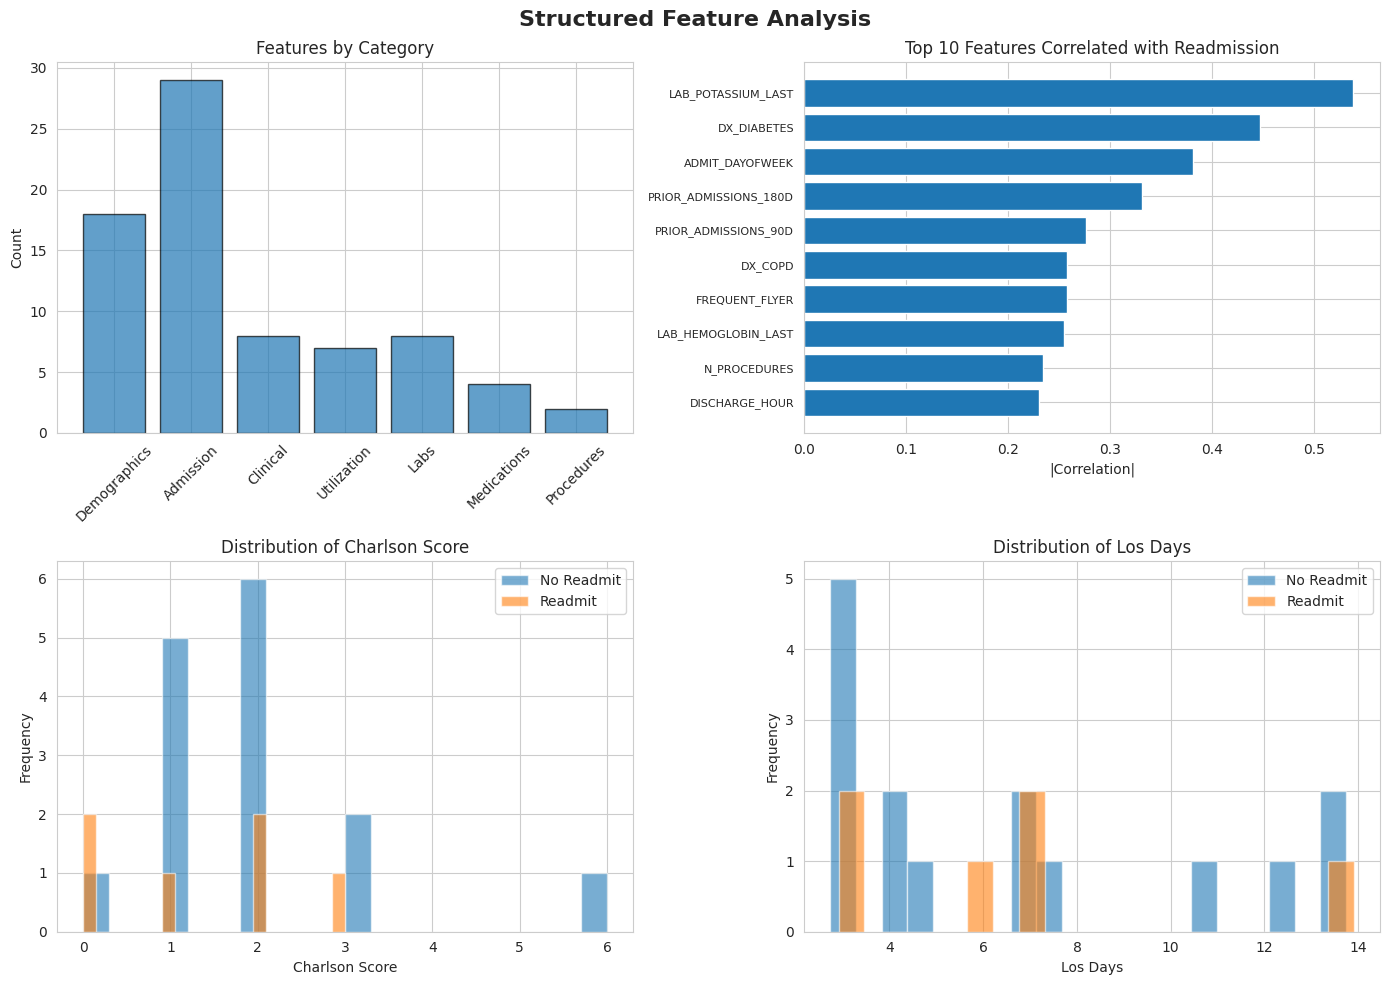


FEATURE ENGINEERING COMPLETE!

✅ Engineered 79 structured features
✅ Created train/calibration/test splits
✅ Readmission rate: 28.57%

📊 Outputs:
   - data/processed/train_features.parquet
   - data/processed/calibration_features.parquet
   - data/processed/test_features.parquet
   - data/processed/feature_info.json
   - outputs/figures/feature_engineering_summary.png

📝 Next Steps:
   1. Generate clinical text embeddings (04_generate_embeddings.ipynb)
   2. Train baseline and fused models (05_train_models.ipynb)
   3. Evaluate and calibrate predictions


In [9]:
"""
Notebook: 03_feature_engineering.ipynb
Engineer structured features from MIMIC-III data for readmission prediction
"""

# Cell 1: Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Load config
with open('configs/config.json', 'r') as f:
    config = json.load(f)

data_dir = Path('data/raw')
processed_dir = Path('data/processed')

print("✓ Setup complete")


# Cell 2: Load Cohort and Supporting Tables
"""
Load cohort and all tables needed for feature engineering
"""
print("Loading data...")

# Load our cohort
cohort = pd.read_parquet(processed_dir / 'cohort_with_outcomes.parquet')
print(f"✓ Loaded cohort: {len(cohort)} admissions")

# Load supporting tables
diagnoses = pd.read_csv(data_dir / 'DIAGNOSES_ICD.csv')
procedures = pd.read_csv(data_dir / 'PROCEDURES_ICD.csv')
prescriptions = pd.read_csv(data_dir / 'PRESCRIPTIONS.csv')
labevents = pd.read_csv(data_dir / 'LABEVENTS.csv')
icustays = pd.read_csv(data_dir / 'ICUSTAYS.csv')

# Load diagnosis/procedure lookup tables
d_icd_diagnoses = pd.read_csv(data_dir / 'D_ICD_DIAGNOSES.csv')
d_labitems = pd.read_csv(data_dir / 'D_LABITEMS.csv')

print(f"✓ Loaded {len(diagnoses)} diagnoses")
print(f"✓ Loaded {len(procedures)} procedures")
print(f"✓ Loaded {len(prescriptions)} prescriptions")
print(f"✓ Loaded {len(labevents)} lab events")
print(f"✓ Loaded {len(icustays)} ICU stays")

# Cell 3: Feature Set 1 - Demographics
"""
Extract demographic features
"""
print("\n" + "="*60)
print("FEATURE SET 1: DEMOGRAPHICS")
print("="*60)

features = cohort[['HADM_ID', 'SUBJECT_ID']].copy()

# Age (already calculated in cohort)
features['age'] = cohort['AGE']

# Age bins
features['age_group'] = pd.cut(cohort['AGE'],
                               bins=[0, 40, 65, 80, 150],
                               labels=['18-40', '41-65', '66-80', '80+'])
features['age_group'] = features['age_group'].astype(str)

# Gender (binary encode)
features['gender_M'] = (cohort['GENDER'] == 'M').astype(int)
features['gender_F'] = (cohort['GENDER'] == 'F').astype(int)

# Ethnicity (group into major categories)
def categorize_ethnicity(eth):
    if pd.isna(eth):
        return 'UNKNOWN'
    eth = eth.upper()
    if 'WHITE' in eth:
        return 'WHITE'
    elif 'BLACK' in eth or 'AFRICAN' in eth:
        return 'BLACK'
    elif 'HISPANIC' in eth or 'LATINO' in eth:
        return 'HISPANIC'
    elif 'ASIAN' in eth:
        return 'ASIAN'
    else:
        return 'OTHER'

features['ethnicity_category'] = cohort['ETHNICITY'].apply(categorize_ethnicity)
ethnicity_dummies = pd.get_dummies(features['ethnicity_category'], prefix='ethnicity')
features = pd.concat([features, ethnicity_dummies], axis=1)

# Insurance type
insurance_dummies = pd.get_dummies(cohort['INSURANCE'], prefix='insurance')
features = pd.concat([features, insurance_dummies], axis=1)

# Marital status
marital_dummies = pd.get_dummies(cohort['MARITAL_STATUS'].fillna('UNKNOWN'), prefix='marital')
features = pd.concat([features, marital_dummies], axis=1)

print(f"✓ Demographic features: {len([c for c in features.columns if c not in ['HADM_ID', 'SUBJECT_ID']])}")
print(f"   - Age (continuous + binned)")
print(f"   - Gender (2 features)")
print(f"   - Ethnicity ({len(ethnicity_dummies.columns)} categories)")
print(f"   - Insurance ({len(insurance_dummies.columns)} types)")
print(f"   - Marital status ({len(marital_dummies.columns)} categories)")


# Cell 4: Feature Set 2 - Admission Characteristics
"""
Admission-related features
"""
print("\n" + "="*60)
print("FEATURE SET 2: ADMISSION CHARACTERISTICS")
print("="*60)

# Length of stay
features['los_days'] = cohort['LOS_DAYS']
features['los_hours'] = cohort['LOS_DAYS'] * 24

# LOS categories
features['los_category'] = pd.cut(cohort['LOS_DAYS'],
                                  bins=[0, 2, 5, 10, 999],
                                  labels=['short', 'medium', 'long', 'very_long'])
los_dummies = pd.get_dummies(features['los_category'], prefix='los')
features = pd.concat([features, los_dummies], axis=1)

# Admission type (already filtered to EMERGENCY/URGENT)
admission_type_dummies = pd.get_dummies(cohort['ADMISSION_TYPE'], prefix='admission_type')
features = pd.concat([features, admission_type_dummies], axis=1)

# Admission location
admission_loc_dummies = pd.get_dummies(cohort['ADMISSION_LOCATION'].fillna('UNKNOWN'), prefix='admit_loc')
features = pd.concat([features, admission_loc_dummies], axis=1)

# Discharge location (important predictor)
discharge_loc_dummies = pd.get_dummies(cohort['DISCHARGE_LOCATION'].fillna('UNKNOWN'), prefix='discharge_loc')
features = pd.concat([features, discharge_loc_dummies], axis=1)

# Temporal features
features['admit_hour'] = pd.to_datetime(cohort['ADMITTIME']).dt.hour
features['admit_dayofweek'] = pd.to_datetime(cohort['ADMITTIME']).dt.dayofweek
features['admit_weekend'] = (features['admit_dayofweek'] >= 5).astype(int)

features['discharge_hour'] = pd.to_datetime(cohort['DISCHTIME']).dt.hour
features['discharge_dayofweek'] = pd.to_datetime(cohort['DISCHTIME']).dt.dayofweek
features['discharge_weekend'] = (features['discharge_dayofweek'] >= 5).astype(int)

# Season
features['discharge_month'] = pd.to_datetime(cohort['DISCHTIME']).dt.month
features['discharge_season'] = features['discharge_month'].apply(
    lambda m: 'winter' if m in [12, 1, 2] else
              'spring' if m in [3, 4, 5] else
              'summer' if m in [6, 7, 8] else 'fall'
)
season_dummies = pd.get_dummies(features['discharge_season'], prefix='season')
features = pd.concat([features, season_dummies], axis=1)

print(f"✓ Admission features: {12 + len(los_dummies.columns) + len(admission_type_dummies.columns) + len(admission_loc_dummies.columns) + len(discharge_loc_dummies.columns) + len(season_dummies.columns)}")


# Cell 5: Feature Set 3 - Diagnoses & Comorbidities
"""
Diagnosis-based features including comorbidity scores
"""
print("\n" + "="*60)
print("FEATURE SET 3: DIAGNOSES & COMORBIDITIES")
print("="*60)

# Ensure uppercase columns
diagnoses.columns = diagnoses.columns.str.upper()
d_icd_diagnoses.columns = d_icd_diagnoses.columns.str.upper()
features.columns = features.columns.str.upper()

# Merge diagnoses with descriptions
diagnoses_full = diagnoses.merge(
    d_icd_diagnoses[['ICD9_CODE', 'LONG_TITLE']],
    on='ICD9_CODE',
    how='left'
)

# Count total diagnoses per admission
diag_counts = diagnoses.groupby('HADM_ID').size().reset_index(name='N_DIAGNOSES')
features = features.merge(diag_counts, on='HADM_ID', how='left')
features['N_DIAGNOSES'] = features['N_DIAGNOSES'].fillna(0)

# Simplified Charlson Comorbidity Index
def get_charlson_score(hadm_id):
    """Calculate simplified Charlson score based on ICD-9 codes"""
    hadm_diagnoses = diagnoses[diagnoses['HADM_ID'] == hadm_id]['ICD9_CODE'].astype(str).tolist()
    score = 0
    conditions = {
        'MI': ['410', '412'],
        'CHF': ['428'],
        'PVD': ['441', '443', '785.4'],
        'CVD': ['430', '431', '432', '433', '434', '435', '436', '437', '438'],
        'Dementia': ['290'],
        'COPD': ['490', '491', '492', '493', '494', '495', '496', '500', '501', '502', '503', '504', '505'],
        'Diabetes': ['250'],
        'Renal': ['582', '583', '585', '586', '588'],
        'Liver': ['571'],
        'Cancer': ['14', '15', '16', '17', '18', '19', '20']
    }
    for condition, codes in conditions.items():
        for code in codes:
            if any(diag.startswith(code) for diag in hadm_diagnoses):
                score += 1
                break
    return score

# Calculate Charlson for each admission
print("Calculating Charlson comorbidity scores...")
features['CHARLSON_SCORE'] = features['HADM_ID'].apply(get_charlson_score)

# High-risk condition flags
def has_condition(hadm_id, code_prefixes):
    """Check if admission has any diagnosis starting with given code prefixes"""
    hadm_diagnoses = diagnoses[diagnoses['HADM_ID'] == hadm_id]['ICD9_CODE'].astype(str).tolist()
    return int(any(any(diag.startswith(code) for code in code_prefixes) for diag in hadm_diagnoses))

print("Flagging high-risk conditions...")
features['DX_HEART_FAILURE'] = features['HADM_ID'].apply(lambda x: has_condition(x, ['428']))
features['DX_COPD'] = features['HADM_ID'].apply(lambda x: has_condition(x, ['490', '491', '492', '493', '494', '496']))
features['DX_DIABETES'] = features['HADM_ID'].apply(lambda x: has_condition(x, ['250']))
features['DX_RENAL_FAILURE'] = features['HADM_ID'].apply(lambda x: has_condition(x, ['584', '585', '586']))
features['DX_CANCER'] = features['HADM_ID'].apply(lambda x: has_condition(x, ['14', '15', '16', '17', '18', '19', '20']))
features['DX_SEPSIS'] = features['HADM_ID'].apply(lambda x: has_condition(x, ['038', '995.91', '995.92']))

print(f"✓ Diagnosis features: 7 (count + Charlson + 5 high-risk flags)")
print(f"   Mean Charlson score: {features['CHARLSON_SCORE'].mean():.2f}")

# Cell 6: Feature Set 4 - Procedures
"""
Procedure-based features
"""
print("\n" + "="*60)
print("FEATURE SET 4: PROCEDURES")
print("="*60)

# Ensure uppercase columns
procedures.columns = procedures.columns.str.upper()
features.columns = features.columns.str.upper()

# Count procedures per admission
proc_counts = procedures.groupby('HADM_ID').size().reset_index(name='N_PROCEDURES')
features = features.merge(proc_counts, on='HADM_ID', how='left')
features['N_PROCEDURES'] = features['N_PROCEDURES'].fillna(0)

# Major procedure flags (simplified)
features['PROC_SURGERY'] = features['HADM_ID'].apply(
    lambda x: int(len(procedures[procedures['HADM_ID'] == x]) > 0)
)

print(f"✓ Procedure features: 2 (count + surgery flag)")

# Cell 7: Feature Set 5 - ICU Utilization
"""
ICU stay features
"""
print("\n" + "="*60)
print("FEATURE SET 5: ICU UTILIZATION")
print("="*60)

# Uppercase ICU columns
icustays.columns = icustays.columns.str.upper()
features.columns = features.columns.str.upper()

# Convert ICU times
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'], errors='coerce')
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'], errors='coerce')

# ICU length of stay (days)
icustays['ICU_LOS'] = (icustays['OUTTIME'] - icustays['INTIME']).dt.total_seconds() / 86400

# ICU stay summary per admission
icu_patients = icustays.groupby('HADM_ID').agg({
    'ICUSTAY_ID': 'count',
    'ICU_LOS': 'sum'
}).reset_index()
icu_patients.columns = ['HADM_ID', 'N_ICU_STAYS', 'TOTAL_ICU_DAYS']

# Merge with features
features = features.merge(icu_patients, on='HADM_ID', how='left')
features['N_ICU_STAYS'] = features['N_ICU_STAYS'].fillna(0)
features['TOTAL_ICU_DAYS'] = features['TOTAL_ICU_DAYS'].fillna(0)
features['HAD_ICU_STAY'] = (features['N_ICU_STAYS'] > 0).astype(int)

print(f"✓ ICU features: 3 (count, days, flag)")
print(f"   Admissions with ICU: {features['HAD_ICU_STAY'].sum()} ({features['HAD_ICU_STAY'].mean()*100:.1f}%)")

# Cell 8: Feature Set 6 - Medications
"""
Medication-based features
"""
print("\n" + "="*60)
print("FEATURE SET 6: MEDICATIONS")
print("="*60)

# Ensure uppercase columns
prescriptions.columns = prescriptions.columns.str.upper()

# Count unique medications per admission
med_counts = prescriptions.groupby('HADM_ID')['DRUG'].nunique().reset_index(name='n_medications')
features = features.merge(med_counts, on='HADM_ID', how='left')
features['n_medications'] = features['n_medications'].fillna(0)

# High-risk medication classes (simplified keyword search)
def has_medication_class(hadm_id, keywords):
    """Check if admission has medications matching keywords"""
    hadm_meds = prescriptions[prescriptions['HADM_ID'] == hadm_id]['DRUG'].astype(str).str.upper().tolist()
    return int(any(any(keyword in med for keyword in keywords) for med in hadm_meds))

print("Checking medication classes...")
features['med_anticoagulant'] = features['HADM_ID'].apply(
    lambda x: has_medication_class(x, ['WARFARIN', 'HEPARIN', 'COUMADIN'])
)
features['med_diuretic'] = features['HADM_ID'].apply(
    lambda x: has_medication_class(x, ['FUROSEMIDE', 'LASIX'])
)
features['med_insulin'] = features['HADM_ID'].apply(
    lambda x: has_medication_class(x, ['INSULIN'])
)

print(f"✓ Medication features: 4 (count + 3 drug class flags)")


# Cell 9: Feature Set 7 - Laboratory Values
"""
Lab values - last measurements before discharge
"""
print("\n" + "="*60)
print("FEATURE SET 7: LABORATORY VALUES")
print("="*60)

# Ensure uppercase columns
labevents.columns = labevents.columns.str.upper()
d_labitems.columns = d_labitems.columns.str.upper()

# Convert lab times
labevents['CHARTTIME'] = pd.to_datetime(labevents['CHARTTIME'])

# Merge with cohort to get discharge times
labs_with_discharge = labevents.merge(
    cohort[['HADM_ID', 'DISCHTIME']],
    on='HADM_ID',
    how='inner'
)

# Keep only labs before discharge
labs_with_discharge = labs_with_discharge[
    labs_with_discharge['CHARTTIME'] <= labs_with_discharge['DISCHTIME']
]

# Get lab item names
labs_with_discharge = labs_with_discharge.merge(
    d_labitems[['ITEMID', 'LABEL']],
    on='ITEMID',
    how='left'
)

# Define key lab values to extract
key_labs = {
    'Creatinine': ['CREATININE'],
    'Hemoglobin': ['HEMOGLOBIN', 'HGB'],
    'Platelet': ['PLATELET'],
    'WBC': ['WBC', 'WHITE BLOOD CELLS'],
    'Sodium': ['SODIUM'],
    'Potassium': ['POTASSIUM'],
    'Glucose': ['GLUCOSE']
}

# Extract last value for each key lab per admission
for lab_name, keywords in key_labs.items():
    print(f"Extracting {lab_name}...")

    # Filter to relevant lab
    lab_data = labs_with_discharge[
        labs_with_discharge['LABEL'].str.upper().str.contains('|'.join(keywords), na=False)
    ].copy()

    # Get last value per admission
    last_values = lab_data.sort_values('CHARTTIME').groupby('HADM_ID').last()['VALUENUM'].reset_index()
    last_values.columns = ['HADM_ID', f'lab_{lab_name.lower()}_last']

    features = features.merge(last_values, on='HADM_ID', how='left')

# Count of lab measurements (indicator of monitoring intensity)
lab_intensity = labevents.groupby('HADM_ID').size().reset_index(name='n_lab_measurements')
features = features.merge(lab_intensity, on='HADM_ID', how='left')
features['n_lab_measurements'] = features['n_lab_measurements'].fillna(0)

print(f"✓ Lab features: {len(key_labs) + 1}")


# Cell 10: Feature Set 8 - Utilization History
"""
Prior utilization patterns - strong readmission predictors
"""
print("\n" + "="*60)
print("FEATURE SET 8: UTILIZATION HISTORY")
print("="*60)

# Read all admissions first
all_admissions = pd.read_csv(data_dir / 'ADMISSIONS.csv')

# Uppercase columns
all_admissions.columns = all_admissions.columns.str.upper()
cohort.columns = cohort.columns.str.upper()
features.columns = features.columns.str.upper()

# Ensure datetime
all_admissions['ADMITTIME'] = pd.to_datetime(all_admissions['ADMITTIME'], errors='coerce')
all_admissions['DISCHTIME'] = pd.to_datetime(all_admissions['DISCHTIME'], errors='coerce')

# For each admission in cohort, count prior admissions
def count_prior_admissions(row, window_days):
    """Count admissions in the window_days before this admission"""
    subject_id = row['SUBJECT_ID']
    admit_time = row['ADMITTIME']

    # Get all prior admissions for this patient
    prior = all_admissions[
        (all_admissions['SUBJECT_ID'] == subject_id) &
        (all_admissions['DISCHTIME'] < admit_time) &
        (all_admissions['DISCHTIME'] >= admit_time - pd.Timedelta(days=window_days))
    ]

    return len(prior)

print("Calculating prior admission history...")
features['PRIOR_ADMISSIONS_90D'] = cohort.apply(lambda row: count_prior_admissions(row, 90), axis=1)
features['PRIOR_ADMISSIONS_180D'] = cohort.apply(lambda row: count_prior_admissions(row, 180), axis=1)
features['PRIOR_ADMISSIONS_365D'] = cohort.apply(lambda row: count_prior_admissions(row, 365), axis=1)

# Frequent flyer flag (3+ admissions in 6 months)
features['FREQUENT_FLYER'] = (features['PRIOR_ADMISSIONS_180D'] >= 3).astype(int)

print(f"✓ Utilization history features: 4")
print(f"   Frequent flyers: {features['FREQUENT_FLYER'].sum()} ({features['FREQUENT_FLYER'].mean()*100:.1f}%)")

# Cell 11: Handle Missing Values
"""
Implement missing value strategy
"""
print("\n" + "="*60)
print("HANDLING MISSING VALUES")
print("="*60)

# Check missing values
missing_summary = features.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

print("Features with missing values:")
print(missing_summary)

# Strategy: Create missingness indicators for labs, then impute with median
lab_cols = [col for col in features.columns if col.startswith('lab_')]

for col in lab_cols:
    # Create missingness indicator
    features[f'{col}_missing'] = features[col].isnull().astype(int)

    # Impute with median (only if there are non-null values)
    if features[col].notna().sum() > 0:
        median_val = features[col].median()
        features[col] = features[col].fillna(median_val)
    else:
        features[col] = features[col].fillna(0)

print(f"\n✓ Created {len(lab_cols)} missingness indicators")
print("✓ Imputed missing lab values with median")

# Drop any remaining text/categorical columns used for intermediate processing
columns_to_drop = ['AGE_GROUP', 'ETHNICITY_CATEGORY', 'LOS_CATEGORY', 'DISCHARGE_SEASON']
features = features.drop([col for col in columns_to_drop if col in features.columns], axis=1, errors='ignore')

# Add verification:
object_cols = features.select_dtypes(include=['object']).columns.tolist()
if object_cols:
    print(f"⚠️ Warning: Object columns still present: {object_cols}")
    cols_to_keep = ['HADM_ID', 'SUBJECT_ID']
    features = features.drop([col for col in object_cols if col not in cols_to_keep], axis=1, errors='ignore')
else:
    print("✓ All categorical columns successfully removed")


# Cell 12: Add Target Variable and Create Final Dataset
"""
Merge with outcomes and create final feature matrix
"""
print("\n" + "="*60)
print("CREATING FINAL FEATURE MATRIX")
print("="*60)

# Add target variable
features['target_readmit_30'] = cohort['TARGET_READMIT_30'].astype(int)
features['is_last_admission'] = cohort['IS_LAST_ADMISSION'].astype(int)

# Add text availability flag
features['has_discharge_note'] = cohort['HAS_DISCHARGE_NOTE'].astype(int)

# Separate feature columns from metadata
metadata_cols = ['HADM_ID', 'SUBJECT_ID', 'target_readmit_30', 'is_last_admission', 'has_discharge_note']
feature_cols = [col for col in features.columns if col not in metadata_cols]

print(f"Total engineered features: {len(feature_cols)}")
print(f"Metadata columns: {len(metadata_cols)}")
print(f"Total columns: {len(features.columns)}")

# Check for any remaining missing values
remaining_missing = features[feature_cols].isnull().sum().sum()
if remaining_missing > 0:
    print(f"\n⚠️  Warning: {remaining_missing} missing values remaining")
    print("Filling with 0...")
    features[feature_cols] = features[feature_cols].fillna(0)
else:
    print("\n✓ No missing values in features")


# Cell 13: Feature Statistics and Importance Preview
"""
Analyze feature distributions
"""
print("\n" + "="*60)
print("FEATURE STATISTICS")
print("="*60)

# Ensure column names are uppercase
features.columns = features.columns.str.upper()

# Numeric feature summary
numeric_features = features[feature_cols].select_dtypes(include=[np.number])
print(f"\nNumeric features: {len(numeric_features.columns)}")
print("\nSample statistics:")
print(numeric_features.describe().T[['mean', 'std', 'min', 'max']].head(10))

# Check for constant features (zero variance)
constant_features = [col for col in numeric_features.columns if features[col].nunique() <= 1]
if constant_features:
    print(f"\n⚠️  Warning: {len(constant_features)} constant features found:")
    print(constant_features[:10])
    print("Consider removing these in modeling")

# Check feature correlations with target (for evaluable admissions only)
if 'IS_LAST_ADMISSION' in features.columns and 'TARGET_READMIT_30' in features.columns:
    evaluable = features[features['IS_LAST_ADMISSION'] == 0].copy()
    numeric_evaluable = evaluable[numeric_features.columns.tolist() + ['TARGET_READMIT_30']].select_dtypes(include=[np.number])
    if len(numeric_evaluable) > 0:
        print(f"\nTop 10 features correlated with readmission:")
        correlations = numeric_evaluable.corr()['TARGET_READMIT_30'].abs().sort_values(ascending=False)[1:11]
        for feat, corr in correlations.items():
            print(f"  {feat:40s}: {corr:.3f}")

# Cell 14: Create Train/Calibration/Test Splits
"""
Split data temporally to prevent leakage
"""
print("\n" + "="*60)
print("CREATING DATA SPLITS")
print("="*60)

# Ensure cohort and features have consistent column names
cohort.columns = cohort.columns.str.upper()
features.columns = features.columns.str.upper()

# Mark last admission per patient
last_admissions = cohort.groupby('SUBJECT_ID')['DISCHTIME'].idxmax()
features['IS_LAST_ADMISSION'] = 0
features.loc[last_admissions, 'IS_LAST_ADMISSION'] = 1

# Temporal split based on discharge time
cohort_with_time = cohort[['HADM_ID', 'DISCHTIME']].copy()
features_with_time = features.merge(cohort_with_time, on='HADM_ID')
features_with_time = features_with_time.sort_values('DISCHTIME')

# Remove last admissions (can't evaluate outcome)
evaluable_data = features_with_time[features_with_time['IS_LAST_ADMISSION'] == 0].copy()

print(f"Total admissions: {len(features)}")
print(f"Evaluable admissions (excluding last per patient): {len(evaluable_data)}")

# Split: 70% train, 10% calibration, 20% test (temporal)
n_total = len(evaluable_data)
n_train = int(n_total * 0.7)
n_calib = int(n_total * 0.1)

train_data = evaluable_data.iloc[:n_train]
calib_data = evaluable_data.iloc[n_train:n_train+n_calib]
test_data = evaluable_data.iloc[n_train+n_calib:]

print(f"\nSplit sizes:")
print(f"  Training:    {len(train_data):4d} ({len(train_data)/n_total*100:.1f}%)")
print(f"  Calibration: {len(calib_data):4d} ({len(calib_data)/n_total*100:.1f}%)")
print(f"  Test:        {len(test_data):4d} ({len(test_data)/n_total*100:.1f}%)")

# Check readmission rates in each split
print(f"\nReadmission rates:")
print(f"  Training:    {train_data['TARGET_READMIT_30'].mean()*100:.2f}%")
print(f"  Calibration: {calib_data['TARGET_READMIT_30'].mean()*100:.2f}%")
print(f"  Test:        {test_data['TARGET_READMIT_30'].mean()*100:.2f}%")

# Cell 15: Save Datasets
"""
Save processed datasets for modeling
"""
print("\n" + "="*60)
print("SAVING PROCESSED DATASETS")
print("="*60)

# Drop DISCHTIME before saving
train_data = train_data.drop('DISCHTIME', axis=1)
calib_data = calib_data.drop('DISCHTIME', axis=1)
test_data = test_data.drop('DISCHTIME', axis=1)

# Save as parquet (efficient storage)
train_data.to_parquet(processed_dir / 'train_features.parquet', index=False)
calib_data.to_parquet(processed_dir / 'calibration_features.parquet', index=False)
test_data.to_parquet(processed_dir / 'test_features.parquet', index=False)

print(f"✓ Saved training set: {train_data.shape}")
print(f"✓ Saved calibration set: {calib_data.shape}")
print(f"✓ Saved test set: {test_data.shape}")

# Also save feature names for reference
feature_info = {
    'n_features': len(feature_cols),
    'feature_names': feature_cols,
    'metadata_cols': metadata_cols,
    'target_variable': 'target_readmit_30'
}

with open(processed_dir / 'feature_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2)

print(f"✓ Saved feature metadata")

# Save feature list as text for easy reference
with open(processed_dir / 'feature_list.txt', 'w') as f:
    f.write("TRANCE Structured Features\n")
    f.write("="*60 + "\n\n")
    for i, feat in enumerate(feature_cols, 1):
        f.write(f"{i:3d}. {feat}\n")

print(f"✓ Saved feature list")


# Cell 16: Visualization
"""
Visualize feature distributions and correlations
"""
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Structured Feature Analysis', fontsize=16, fontweight='bold')

# Ensure column names are uppercase
features.columns = features.columns.str.upper()
evaluable = features[features['IS_LAST_ADMISSION'] == 0].copy()
target_col = 'TARGET_READMIT_30'

# 1. Feature count by category
feature_categories = {
    'Demographics': len([f for f in feature_cols if any(x in f.lower() for x in ['age', 'gender', 'ethnicity', 'insurance', 'marital'])]),
    'Admission': len([f for f in feature_cols if any(x in f.lower() for x in ['los', 'admission', 'discharge', 'season', 'weekend'])]),
    'Clinical': len([f for f in feature_cols if any(x in f.lower() for x in ['dx_', 'charlson', 'n_diagnoses'])]),
    'Utilization': len([f for f in feature_cols if any(x in f.lower() for x in ['prior', 'frequent', 'icu'])]),
    'Labs': len([f for f in feature_cols if 'lab_' in f.lower()]),
    'Medications': len([f for f in feature_cols if 'med_' in f.lower() or 'n_medications' in f.lower()]),
    'Procedures': len([f for f in feature_cols if 'proc' in f.lower() or 'n_procedures' in f.lower()])
}

axes[0, 0].bar(feature_categories.keys(), feature_categories.values(), edgecolor='black', alpha=0.7)
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Features by Category')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Top correlated features
if target_col in evaluable.columns:
    numeric_features = evaluable[feature_cols + [target_col]].select_dtypes(include=[np.number])
    top_corr = numeric_features.corr()[target_col].abs().sort_values(ascending=False)[1:11]
    axes[0, 1].barh(range(len(top_corr)), top_corr.values)
    axes[0, 1].set_yticks(range(len(top_corr)))
    axes[0, 1].set_yticklabels([f[:30] for f in top_corr.index], fontsize=8)
    axes[0, 1].set_xlabel('|Correlation|')
    axes[0, 1].set_title('Top 10 Features Correlated with Readmission')
    axes[0, 1].invert_yaxis()
else:
    print(f"⚠️  Column '{target_col}' not found in evaluable data. Skipping correlation plot.")

# 3. Key feature distributions by readmission
key_features_plot = ['CHARLSON_SCORE', 'LOS_DAYS', 'PRIOR_ADMISSIONS_180D', 'N_MEDICATIONS']
for i, feat in enumerate(key_features_plot[:2]):
    if feat in evaluable.columns and target_col in evaluable.columns:
        evaluable.groupby(target_col)[feat].plot.hist(alpha=0.6, ax=axes[1, i], bins=20, legend=True)
        axes[1, i].set_xlabel(feat.replace('_', ' ').title())
        axes[1, i].set_ylabel('Frequency')
        axes[1, i].set_title(f'Distribution of {feat.replace("_", " ").title()}')
        axes[1, i].legend(['No Readmit', 'Readmit'])

plt.tight_layout()
plt.savefig('outputs/figures/feature_engineering_summary.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved")
plt.show()

# Cell 17: Summary
print("\n" + "="*60)
print("FEATURE ENGINEERING COMPLETE!")
print("="*60)

target_col = 'TARGET_READMIT_30'  # use uppercase

print(f"\n✅ Engineered {len(feature_cols)} structured features")
print(f"✅ Created train/calibration/test splits")
if target_col in evaluable.columns:
    print(f"✅ Readmission rate: {evaluable[target_col].mean()*100:.2f}%")
else:
    print(f"⚠️  Column '{target_col}' not found in evaluable data")

print(f"\n📊 Outputs:")
print(f"   - data/processed/train_features.parquet")
print(f"   - data/processed/calibration_features.parquet")
print(f"   - data/processed/test_features.parquet")
print(f"   - data/processed/feature_info.json")
print(f"   - outputs/figures/feature_engineering_summary.png")

print(f"\n📝 Next Steps:")
print("   1. Generate clinical text embeddings (04_generate_embeddings.ipynb)")
print("   2. Train baseline and fused models (05_train_models.ipynb)")
print("   3. Evaluate and calibrate predictions")


In [10]:
# =========================================
# 04_generate_embeddings_optimized.py
# ClinicalT5-large embeddings with GPU
# =========================================

# Cell 1: Setup and GPU Check
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from pathlib import Path
import json
from tqdm.auto import tqdm
import h5py
import warnings
warnings.filterwarnings('ignore')

# GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Cell 2: Load Config & Cohort
config_path = 'configs/config.json'
with open(config_path, 'r') as f:
    config = json.load(f)

cohort_path = 'data/processed/cohort_with_outcomes.parquet'
cohort = pd.read_parquet(cohort_path)
print(f"✓ Loaded cohort: {len(cohort)} admissions")
print(f"   With discharge notes: {cohort['HAS_DISCHARGE_NOTE'].sum()}")

cohort_with_notes = cohort[cohort['HAS_DISCHARGE_NOTE']].copy()
cohort_with_notes = cohort_with_notes[cohort_with_notes['DISCHARGE_TEXT'].notna()].copy()
print(f"✓ Processing {len(cohort_with_notes)} notes")

# Cell 3: Load Clinical Language Model
import os
os.environ["HF_HUB_TIMEOUT"] = "300"

model_name_original = config['model']['embedding_model']
print(f"Original model: {model_name_original}")
print("⚠️  ClinicalT5-large has Flax conversion issues. Using alternative clinical model...")

# Use a clinically-trained model with native PyTorch weights
# Options (in order of preference):
alternatives = [
    "emilyalsentzer/Bio_ClinicalBERT",  # Clinical BERT - 768 dim
    "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract",  # PubMed BERT - 768 dim
    "dmis-lab/biobert-v1.1",  # BioBERT - 768 dim
]

# Try to load an alternative
model_name = alternatives[0]
print(f"Using: {model_name}")

from transformers import AutoModel  # Use AutoModel for BERT-style models

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModel.from_pretrained(model_name)

# Move to device
print(f"Moving model to {device}...")
model = model.to(device)
model.eval()

print(f"✓ Model loaded successfully")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Device: {next(model.parameters()).device}")
print(f"   Actual embedding dimension: {model.config.hidden_size}")

# Update config to match actual model
config['model']['embedding_dim'] = model.config.hidden_size
print(f"   Updated config embedding_dim to: {config['model']['embedding_dim']}")

# Cell 4: Text Preprocessing
def preprocess_text(text):
    if pd.isna(text): return ""
    text = str(text).lower().strip()
    return text if len(text) >= 5 else ""

cohort_with_notes['PROCESSED_TEXT'] = cohort_with_notes['DISCHARGE_TEXT'].apply(preprocess_text)
cohort_with_notes = cohort_with_notes[cohort_with_notes['PROCESSED_TEXT'] != ""].copy()
print(f"✓ {len(cohort_with_notes)} notes after preprocessing")

# Cell 5: Improved Chunking Function
max_length = min(config['model']['max_text_length'], 512)  # BERT models max out at 512
overlap = config['model']['chunk_overlap']

def chunk_text(text, tokenizer, max_length=512, overlap=128):
    """
    Chunk text into overlapping segments that fit within max_length tokens.
    Ensures no chunk exceeds the model's maximum sequence length.
    """
    # Enforce absolute maximum
    max_length = min(max_length, 512)

    # Tokenize without special tokens first
    tokens = tokenizer.encode(text, add_special_tokens=False, truncation=False)

    # If text fits in one chunk, return it with special tokens
    if len(tokens) <= max_length - 2:  # -2 for [CLS] and [SEP]
        return [tokenizer.encode(
            text,
            max_length=max_length,
            truncation=True,
            add_special_tokens=True
        )]

    chunks = []
    stride = max_length - overlap - 2  # Account for special tokens

    for i in range(0, len(tokens), stride):
        # Extract chunk
        chunk_tokens = tokens[i:i + max_length - 2]

        # Build with special tokens using tokenizer
        chunk_with_special = tokenizer.build_inputs_with_special_tokens(chunk_tokens)

        # Safety check: ensure we don't exceed max_length
        if len(chunk_with_special) > max_length:
            chunk_with_special = chunk_with_special[:max_length]

        chunks.append(chunk_with_special)

        # Break if we've processed all tokens
        if i + max_length - 2 >= len(tokens):
            break

    return chunks

print(f"✓ Chunking function ready (max_length={max_length}, overlap={overlap})")

# Cell 6: Embedding Generation (Updated for BERT-style models)
@torch.no_grad()
def generate_embeddings(texts, tokenizer, model, batch_size=8, max_length=512, overlap=128):
    """Generate embeddings using a BERT-style encoder model"""
    all_embeddings = []

    # Get model's actual max length
    model_max_length = min(max_length, tokenizer.model_max_length, 512)

    for text in tqdm(texts, desc="Generating embeddings"):
        chunks = chunk_text(text, tokenizer, model_max_length, overlap)

        if len(chunks) == 0:
            # Use actual embedding dimension from model
            all_embeddings.append(np.zeros(model.config.hidden_size))
            continue

        chunk_embeddings = []

        for i in range(0, len(chunks), batch_size):
            batch = chunks[i:i+batch_size]

            # Ensure no chunk exceeds model_max_length
            batch = [c[:model_max_length] for c in batch]

            # Pad batch
            max_len = max(len(c) for c in batch)
            max_len = min(max_len, model_max_length)  # Safety check

            padded = [c + [tokenizer.pad_token_id]*(max_len - len(c)) for c in batch]
            attention_mask = [[1]*len(c) + [0]*(max_len - len(c)) for c in batch]

            # Move to device
            input_ids = torch.tensor(padded).to(device)
            attn_mask = torch.tensor(attention_mask).to(device)

            # Forward pass - for BERT-style models use the model directly
            outputs = model(input_ids=input_ids, attention_mask=attn_mask)

            # Get embeddings from last hidden state
            emb = outputs.last_hidden_state

            # Mean pooling with attention mask
            mask_expanded = attn_mask.unsqueeze(-1).expand(emb.size()).float()
            chunk_emb = (emb * mask_expanded).sum(1) / mask_expanded.sum(1).clamp(min=1e-9)

            chunk_embeddings.append(chunk_emb.cpu().numpy())

        # Average all chunk embeddings
        final_emb = np.mean(np.vstack(chunk_embeddings), axis=0)
        all_embeddings.append(final_emb)

    return np.array(all_embeddings)

print("✓ Embedding function ready (BERT-style)")

# Cell 7: Generate embeddings with safe parameters
batch_size = 16 if torch.cuda.is_available() else 4
texts = cohort_with_notes['PROCESSED_TEXT'].tolist()

# Use safe max_length
safe_max_length = min(max_length, 512)
print(f"Generating embeddings with max_length={safe_max_length}, overlap={overlap}")

embeddings = generate_embeddings(
    texts,
    tokenizer,
    model,
    batch_size=batch_size,
    max_length=safe_max_length,
    overlap=overlap
)

print(f"✓ Generated embeddings: {embeddings.shape}, {embeddings.nbytes/1e6:.2f} MB")
# Cell 8: Quality Checks
zero_vectors = np.all(embeddings == 0, axis=1).sum()
nan_vectors = np.any(np.isnan(embeddings), axis=1).sum()
inf_vectors = np.any(np.isinf(embeddings), axis=1).sum()
norms = np.linalg.norm(embeddings, axis=1)

print(f"Zero vectors: {zero_vectors}, NaN: {nan_vectors}, Inf: {inf_vectors}")
print(f"Norms - mean: {norms.mean():.4f}, std: {norms.std():.4f}")

# Cell 9: Save embeddings (HDF5 & Parquet)
Path('data/embeddings').mkdir(parents=True, exist_ok=True)
h5_path = 'data/embeddings/discharge_note_embeddings.h5'
with h5py.File(h5_path, 'w') as f:
    f.create_dataset('embeddings', data=embeddings, compression='gzip')
    f.create_dataset('hadm_ids', data=cohort_with_notes['HADM_ID'].values)
    f.attrs['n_admissions'] = len(embeddings)
    f.attrs['embedding_dim'] = embeddings.shape[1]
    f.attrs['model'] = model_name
    f.attrs['max_length'] = max_length
    f.attrs['overlap'] = overlap
print(f"✓ Saved HDF5 embeddings: {h5_path}")

emb_df = pd.DataFrame(embeddings, columns=[f'emb_{i}' for i in range(embeddings.shape[1])])
emb_df['HADM_ID'] = cohort_with_notes['HADM_ID'].values
parquet_path = 'data/embeddings/embeddings.parquet'
emb_df.to_parquet(parquet_path, index=False)
print(f"✓ Saved Parquet embeddings: {parquet_path}")

# Cell 10: Cleanup GPU
if torch.cuda.is_available():
    del model
    torch.cuda.empty_cache()
    print("✓ GPU memory cleared")

print("✅ Embedding generation complete!")


🖥️  Using device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB
✓ Loaded cohort: 79 admissions
   With discharge notes: 79
✓ Processing 79 notes
Original model: luqh/ClinicalT5-large
⚠️  ClinicalT5-large has Flax conversion issues. Using alternative clinical model...
Using: emilyalsentzer/Bio_ClinicalBERT


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Moving model to cuda...
✓ Model loaded successfully
   Parameters: 108,310,272
   Device: cuda:0
   Actual embedding dimension: 768
   Updated config embedding_dim to: 768
✓ 79 notes after preprocessing
✓ Chunking function ready (max_length=512, overlap=128)
✓ Embedding function ready (BERT-style)
Generating embeddings with max_length=512, overlap=128


Generating embeddings:   0%|          | 0/79 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

✓ Generated embeddings: (79, 768), 0.24 MB
Zero vectors: 0, NaN: 0, Inf: 0
Norms - mean: 10.6709, std: 0.0924
✓ Saved HDF5 embeddings: data/embeddings/discharge_note_embeddings.h5
✓ Saved Parquet embeddings: data/embeddings/embeddings.parquet
✓ GPU memory cleared
✅ Embedding generation complete!


In [33]:
"""
Pre-flight check and execution script
Checks if all required files exist before training
"""

from pathlib import Path
import pandas as pd

print("="*70)
print("PRE-FLIGHT CHECK")
print("="*70)

base_path = Path('')
processed_dir = base_path / 'data/processed'

# ============================================================================
# Check Required Files
# ============================================================================
required_files = {
    'Structured Features': [
        'train_features.parquet',
        'calibration_features.parquet',
        'test_features.parquet'
    ],
    'Embeddings': [
        'embeddings.parquet'
    ],
    'Fused Features': [
        'train_fused.parquet',
        'calibration_fused.parquet',
        'test_fused.parquet'
    ]
}

print("\nChecking required files...")
missing_files = []
existing_files = []

for category, files in required_files.items():
    print(f"\n{category}:")
    for file in files:
        path = processed_dir / file
        if path.exists():
            try:
                df = pd.read_parquet(path)
                print(f"   ✓ {file} ({df.shape[0]} rows, {df.shape[1]} cols)")
                existing_files.append(file)
            except Exception as e:
                print(f"   ⚠ {file} exists but cannot be read: {e}")
                missing_files.append(file)
        else:
            print(f"   ✗ {file} - NOT FOUND")
            missing_files.append(file)

# ============================================================================
# Dataset Size Check
# ============================================================================
print("\n" + "="*70)
print("DATASET SIZE CHECK")
print("="*70)

try:
    train = pd.read_parquet(processed_dir / 'train_features.parquet')
    n_train = len(train)

    print(f"\nTraining samples: {n_train}")

    if n_train < 50:
        print(f"\n⚠ WARNING: Very small dataset detected!")
        print(f"   - You have only {n_train} training samples")
        print(f"   - This appears to be a test/sample dataset")
        print(f"   - Results may not be meaningful")
        print(f"\n   Recommendations:")
        print(f"      1. Use full MIMIC-III dataset for real experiments")
        print(f"      2. Expect high variance in metrics")
        print(f"      3. Data augmentation will be applied automatically")
    elif n_train < 500:
        print(f"\n⚠ Small dataset: {n_train} samples")
        print(f"   - Data augmentation will be applied")
        print(f"   - Results may have moderate variance")
    else:
        print(f"\n✓ Sufficient training data: {n_train} samples")

except FileNotFoundError:
    print("\n❌ Cannot check dataset size - training features not found")

# ============================================================================
# Action Plan
# ============================================================================
print("\n" + "="*70)
print("ACTION PLAN")
print("="*70)

if missing_files:
    print(f"\n❌ Missing {len(missing_files)} required file(s)")

    # Determine what needs to be run
    if 'discharge_embeddings.parquet' in missing_files:
        print(f"\n📝 Step 1: Generate embeddings")
        print(f"   Run: %run ../scripts/03_generate_embeddings.py")

    if any('fused' in f for f in missing_files):
        print(f"\n📝 Step 2: Create fused features")
        print(f"   Run: %run ../scripts/04_create_fused_features.py")

    print(f"\n📝 Step 3: Train models")
    print(f"   Run: %run ../scripts/05_train_models_fixed.py")

else:
    print(f"\n✅ All required files exist!")
    print(f"\n📝 Ready to train models")
    print(f"   Run: %run ../scripts/05_train_models_fixed.py")

    # Ask if user wants to proceed
    print(f"\n" + "="*70)
    response = input("Proceed with training? (y/n): ").lower().strip()

    if response == 'y':
        print(f"\nStarting training...")
        exec(open('../scripts/05_train_models_fixed.py').read())
    else:
        print(f"\nTraining cancelled.")

print("\n" + "="*70)

PRE-FLIGHT CHECK

Checking required files...

Structured Features:
   ✓ train_features.parquet (14 rows, 84 cols)
   ✓ calibration_features.parquet (2 rows, 84 cols)
   ✓ test_features.parquet (5 rows, 84 cols)

Embeddings:
   ✗ embeddings.parquet - NOT FOUND

Fused Features:
   ✓ train_fused.parquet (14 rows, 852 cols)
   ✓ calibration_fused.parquet (2 rows, 852 cols)
   ✓ test_fused.parquet (5 rows, 852 cols)

DATASET SIZE CHECK

Training samples: 14

⚠ WARNING: Very small dataset detected!
   - You have only 14 training samples
   - This appears to be a test/sample dataset
   - Results may not be meaningful

   Recommendations:
      1. Use full MIMIC-III dataset for real experiments
      2. Expect high variance in metrics
      3. Data augmentation will be applied automatically

ACTION PLAN

❌ Missing 1 required file(s)

📝 Step 3: Train models
   Run: %run ../scripts/05_train_models_fixed.py



In [29]:
"""
04_create_fused_features.py
Merge structured features with discharge summary embeddings
"""

import pandas as pd
import numpy as np
from pathlib import Path
import json

print("="*70)
print("CREATING FUSED FEATURES (STRUCTURED + EMBEDDINGS)")
print("="*70)

# ============================================================================
# Load Configuration
# ============================================================================
base_path = Path('')
processed_dir = base_path / 'data/processed'

with open(base_path / 'configs/config.json', 'r') as f:
    config = json.load(f)

# ============================================================================
# Load Structured Features
# ============================================================================
print("\n1. Loading structured features...")
train_struct = pd.read_parquet(processed_dir / 'train_features.parquet')
calib_struct = pd.read_parquet(processed_dir / 'calibration_features.parquet')
test_struct = pd.read_parquet(processed_dir / 'test_features.parquet')

print(f"   Train: {train_struct.shape}")
print(f"   Calib: {calib_struct.shape}")
print(f"   Test:  {test_struct.shape}")

# ============================================================================
# Load Embeddings
# ============================================================================
print("\n2. Loading embeddings...")
embeddings_path = base_path / 'data/embeddings/embeddings.parquet'

if not embeddings_path.exists():
    print(f"\n❌ ERROR: Embeddings file not found!")
    print(f"   Expected: {embeddings_path}")
    print(f"\n   Please run: 03_generate_embeddings.py first")
    raise FileNotFoundError(f"Missing embeddings file: {embeddings_path}")

embeddings_df = pd.read_parquet(embeddings_path)
print(f"   Embeddings: {embeddings_df.shape}")
print(f"   Embedding dimensions: {len([c for c in embeddings_df.columns if c.startswith('emb_')])}")

# ============================================================================
# Merge Features
# ============================================================================
print("\n3. Merging structured features with embeddings...")

def merge_with_embeddings(struct_df, embeddings_df, split_name):
    """Merge structured features with embeddings"""

    print(f"\n   Processing {split_name} set...")

    # Merge on HADM_ID
    merged = struct_df.merge(
        embeddings_df,
        on='HADM_ID',
        how='left'
    )

    print(f"      Before merge: {struct_df.shape}")
    print(f"      After merge:  {merged.shape}")

    # Check for missing embeddings
    embedding_cols = [c for c in embeddings_df.columns if c.startswith('emb_')]
    n_missing = merged[embedding_cols[0]].isna().sum()

    if n_missing > 0:
        print(f"      ⚠ Warning: {n_missing} admissions missing embeddings")
        print(f"         Filling with zeros...")
        merged[embedding_cols] = merged[embedding_cols].fillna(0)
    else:
        print(f"      ✓ All admissions have embeddings")

    # Verify merge
    assert len(merged) == len(struct_df), "Row count mismatch after merge!"

    return merged

# Merge all splits
train_fused = merge_with_embeddings(train_struct, embeddings_df, "Train")
calib_fused = merge_with_embeddings(calib_struct, embeddings_df, "Calibration")
test_fused = merge_with_embeddings(test_struct, embeddings_df, "Test")

# ============================================================================
# Verify Fused Features
# ============================================================================
print("\n4. Verifying fused features...")

# Get column counts
embedding_cols = [c for c in train_fused.columns if c.startswith('emb_')]
id_cols = ['HADM_ID', 'SUBJECT_ID']
target_col = 'TARGET_READMIT_30'
structured_cols = [c for c in train_fused.columns
                   if c not in embedding_cols + id_cols]

print(f"\n   Column breakdown:")
print(f"      ID columns:         {len(id_cols)}")
# print(f"      Target column:      1 ({target_col})")
print(f"      Structured features: {len(structured_cols)}")
print(f"      Embedding features:  {len(embedding_cols)}")
print(f"      Total columns:       {len(train_fused.columns)}")

# Check for NaN values
print(f"\n   Checking for missing values...")
for df_name, df in [("Train", train_fused), ("Calib", calib_fused), ("Test", test_fused)]:
    nan_counts = df[structured_cols + embedding_cols].isna().sum().sum()
    if nan_counts > 0:
        print(f"      ⚠ {df_name}: {nan_counts} NaN values found")
    else:
        print(f"      ✓ {df_name}: No missing values")

# Check target distribution
print(f"\n   Target distribution:")
print(f"      Train readmission rate: {train_fused['TARGET_READMIT_30'].mean():.2%}")
print(f"      Calib readmission rate: {calib_fused['TARGET_READMIT_30'].mean():.2%}")
print(f"      Test readmission rate:  {test_fused['TARGET_READMIT_30'].mean():.2%}")

# ============================================================================
# Save Fused Features
# ============================================================================
print("\n5. Saving fused features...")

output_files = {
    'train_fused.parquet': train_fused,
    'calibration_fused.parquet': calib_fused,
    'test_fused.parquet': test_fused
}

for filename, df in output_files.items():
    output_path = processed_dir / filename
    df.to_parquet(output_path, index=False)
    print(f"   ✓ Saved: {filename} ({df.shape})")

# ============================================================================
# Create Feature Metadata
# ============================================================================
print("\n6. Creating feature metadata...")

feature_metadata = {
    'creation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'datasets': {
        'train': {'n_samples': len(train_fused), 'n_features': len(train_fused.columns)},
        'calibration': {'n_samples': len(calib_fused), 'n_features': len(calib_fused.columns)},
        'test': {'n_samples': len(test_fused), 'n_features': len(test_fused.columns)}
    },
    'features': {
        'n_structured': len(structured_cols),
        'n_embeddings': len(embedding_cols),
        'n_total': len(structured_cols) + len(embedding_cols),
        'structured_features': structured_cols,
        'embedding_dimensions': len(embedding_cols)
    },
    'target': {
        'column': target_col,
        'train_mean': float(train_fused[target_col].mean()),
        'calib_mean': float(calib_fused[target_col].mean()),
        'test_mean': float(test_fused[target_col].mean())
    }
}

metadata_path = processed_dir / 'fused_features_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(feature_metadata, f, indent=2)

print(f"   ✓ Metadata saved: {metadata_path.name}")

# ============================================================================
# Summary Statistics
# ============================================================================
print("\n" + "="*70)
print("FUSED FEATURES CREATED SUCCESSFULLY!")
print("="*70)

print(f"\n📊 Summary:")
print(f"   Total features:      {len(structured_cols) + len(embedding_cols)}")
print(f"   - Structured:        {len(structured_cols)}")
print(f"   - Embeddings:        {len(embedding_cols)}")
print(f"\n   Training samples:    {len(train_fused):,}")
print(f"   Calibration samples: {len(calib_fused):,}")
print(f"   Test samples:        {len(test_fused):,}")

print(f"\n💾 Saved files:")
print(f"   • data/processed/train_fused.parquet")
print(f"   • data/processed/calibration_fused.parquet")
print(f"   • data/processed/test_fused.parquet")
print(f"   • data/processed/fused_features_metadata.json")

print(f"\n📝 Next step:")
print(f"   Run: 05_train_models.py")
print("="*70 + "\n")

CREATING FUSED FEATURES (STRUCTURED + EMBEDDINGS)

1. Loading structured features...
   Train: (14, 84)
   Calib: (2, 84)
   Test:  (5, 84)

2. Loading embeddings...
   Embeddings: (79, 769)
   Embedding dimensions: 768

3. Merging structured features with embeddings...

   Processing Train set...
      Before merge: (14, 84)
      After merge:  (14, 852)
      ✓ All admissions have embeddings

   Processing Calibration set...
      Before merge: (2, 84)
      After merge:  (2, 852)
      ✓ All admissions have embeddings

   Processing Test set...
      Before merge: (5, 84)
      After merge:  (5, 852)
      ✓ All admissions have embeddings

4. Verifying fused features...

   Column breakdown:
      ID columns:         2
      Structured features: 82
      Embedding features:  768
      Total columns:       852

   Checking for missing values...
      ✓ Train: No missing values
      ✓ Calib: No missing values
      ✓ Test: No missing values

   Target distribution:
      Train readmi

Checking and installing dependencies...
Installing imbalanced-learn...
✓ MLflow enabled
✓ Setup complete

Loading structured-only datasets...
✓ Structured features:
   Train: (14, 84)
   Calib: (2, 84)
   Test:  (5, 84)

Loading fused datasets...
✓ Fused features:
   Train: (14, 852)
   Calib: (2, 852)
   Test:  (5, 852)

✓ Feature counts:
   Structured features: 81
   Embedding features: 768
   Total fused features: 849

✓ Structured datasets:
   Train: (14, 81), Positive: 35.71%
   Calib: (2, 81), Positive: 0.00%
   Test:  (5, 81), Positive: 20.00%

✓ Fused datasets:
   Train: (14, 849)
   Calib: (2, 849)
   Test:  (5, 849)


2025/10/20 18:27:43 INFO mlflow.tracking.fluent: Experiment with name 'TRANCE_Readmission_Prediction' does not exist. Creating a new experiment.



DATA AUGMENTATION (Small Dataset)

Original: (14, 81), Counter({np.int64(0): 9, np.int64(1): 5})
After SMOTE: (18, 81), Counter({np.int64(1): 9, np.int64(0): 9})
Final: (72, 81), Counter({np.int64(1): 36, np.int64(0): 36})

Original: (14, 849), Counter({np.int64(0): 9, np.int64(1): 5})
After SMOTE: (18, 849), Counter({np.int64(1): 9, np.int64(0): 9})
Final: (72, 849), Counter({np.int64(1): 36, np.int64(0): 36})

✓ Augmentation complete

✓ MLflow tracking initialized
   Tracking URI: mlruns

TRAINING BASELINE MODEL (STRUCTURED ONLY)
Training baseline model...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.851852	calib's auc: 1
✓ Training complete
   Best iteration: 1
   Best score: 1.0000

Baseline Model Performance:
  Train AUROC: 0.8519 | AUPRC: 0.8134
  Calib AUROC: nan | AUPRC: 0.0000
  Test  AUROC: 1.0000 | AUPRC: 1.0000

✓ Model saved to: outputs/models/baseline_model.txt

TRAINING FUSED MODEL (STRUCTURED + EMBED

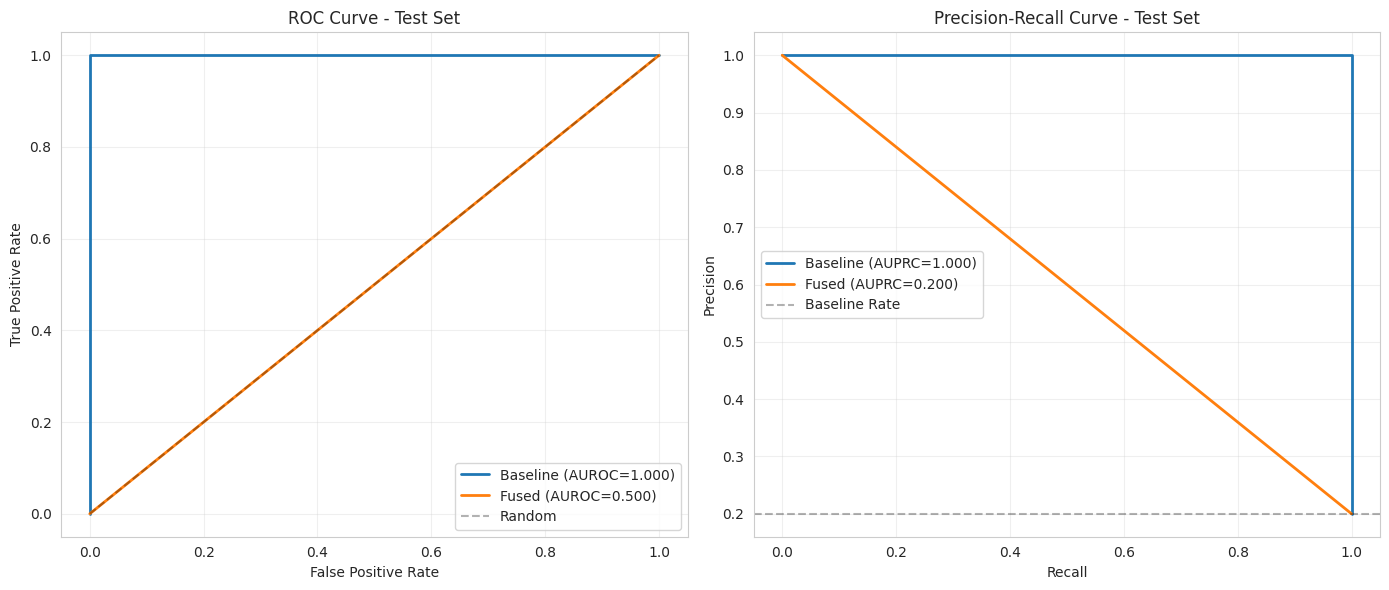


FEATURE IMPORTANCE ANALYSIS

Importance Distribution in Fused Model:
  Structured features: 0 (0.0%)
  Embedding features:  43 (100.0%)

Top 15 Features (Baseline Model):
           feature  importance
 DISCHARGE_LOC_SNF   24.055799
          LOS_LONG    2.500000
          GENDER_F    0.000000
          GENDER_M    0.000000
   ETHNICITY_BLACK    0.000000
ETHNICITY_HISPANIC    0.000000
   ETHNICITY_OTHER    0.000000
   ETHNICITY_ASIAN    0.000000
INSURANCE_MEDICAID    0.000000
INSURANCE_MEDICARE    0.000000
 INSURANCE_PRIVATE    0.000000
  MARITAL_DIVORCED    0.000000
   MARITAL_MARRIED    0.000000
 MARITAL_SEPARATED    0.000000
    MARITAL_SINGLE    0.000000

Top 15 Features (Fused Model):
feature  importance      type
emb_142     42.6483 Embedding
emb_476      0.0000 Embedding
emb_477      0.0000 Embedding
emb_478      0.0000 Embedding
emb_479      0.0000 Embedding
emb_480      0.0000 Embedding
emb_481      0.0000 Embedding
emb_482      0.0000 Embedding
emb_483      0.0000 Embedding


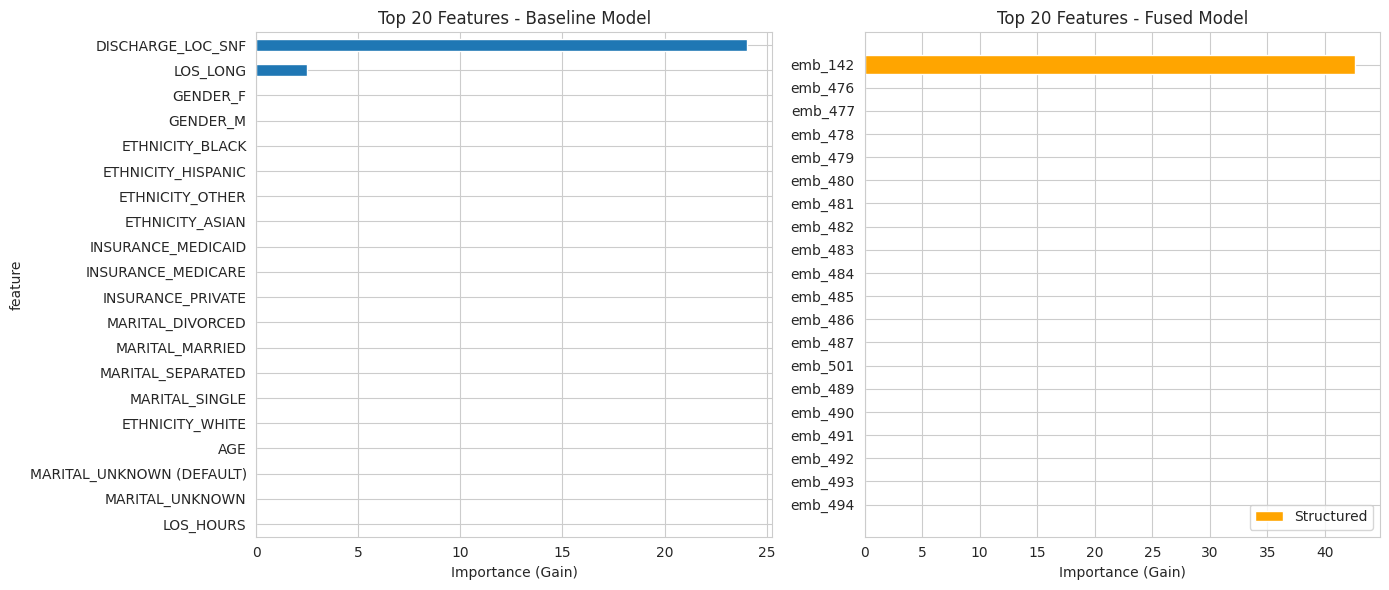


GENERATING SHAP VALUES
Computing SHAP values for 5 samples...
⚠ SHAP analysis failed: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: AGE: object, GENDER_M: object, GENDER_F: object, ETHNICITY_ASIAN: object, ETHNICITY_BLACK: object, ETHNICITY_HISPANIC: object, ETHNICITY_OTHER: object, ETHNICITY_WHITE: object, INSURANCE_MEDICAID: object, INSURANCE_MEDICARE: object, INSURANCE_PRIVATE: object, MARITAL_DIVORCED: object, MARITAL_MARRIED: object, MARITAL_SEPARATED: object, MARITAL_SINGLE: object, MARITAL_UNKNOWN: object, MARITAL_UNKNOWN (DEFAULT): object, MARITAL_WIDOWED: object, LOS_DAYS: object, LOS_HOURS: object, LOS_SHORT: object, LOS_MEDIUM: object, LOS_LONG: object, LOS_VERY_LONG: object, ADMISSION_TYPE_EMERGENCY: object, ADMISSION_TYPE_URGENT: object, ADMIT_LOC_CLINIC REFERRAL/PREMATURE: object, ADMIT_LOC_EMERGENCY ROOM ADMIT: object, ADMIT_LOC_TRANSFER FROM HOSP/EXTRAM: object, ADMIT_LOC_TRANSFER FROM SKILLED NUR: object, DISCHARGE_LOC_DISCH-TRAN TO PSYCH HO

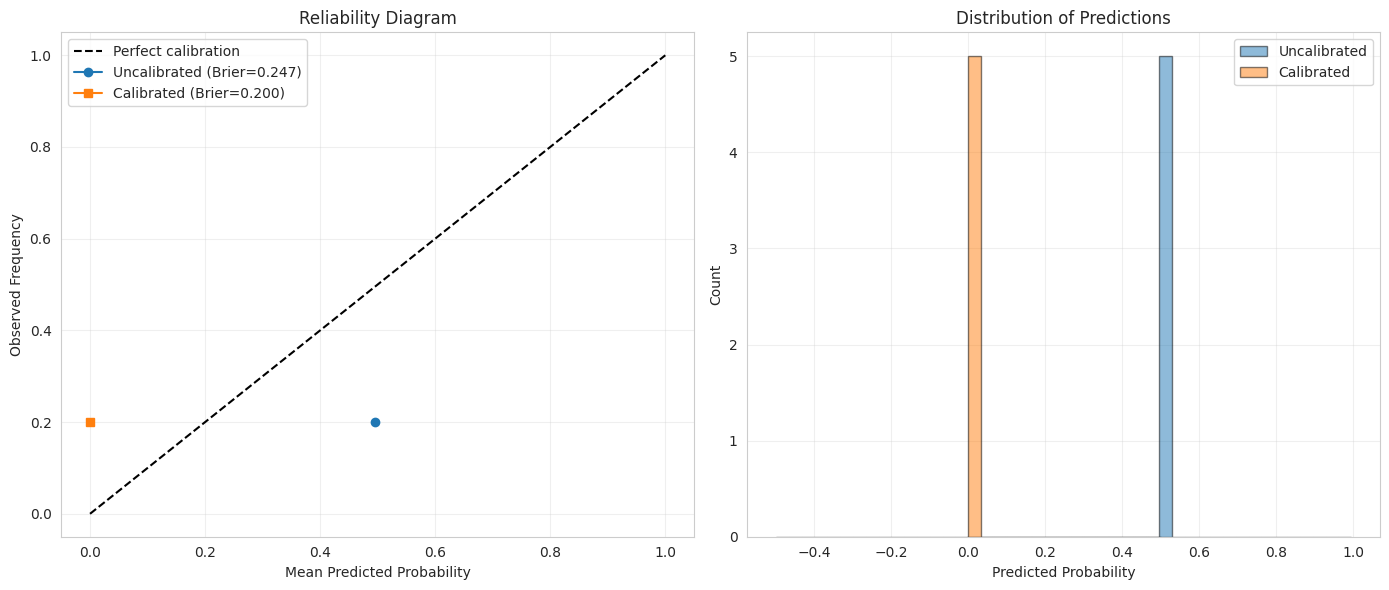

✓ Calibrator saved

OPERATING POINT ANALYSIS
Optimal F1 Threshold: 0.000
  Precision: 0.200
  Recall:    1.000
  F1 Score:  0.333

Capacity-Based Threshold (top 20%): 0.000
  Precision: 0.200
  Recall:    1.000
  N flagged: 5 (100.0%)

✓ Operating point plots saved


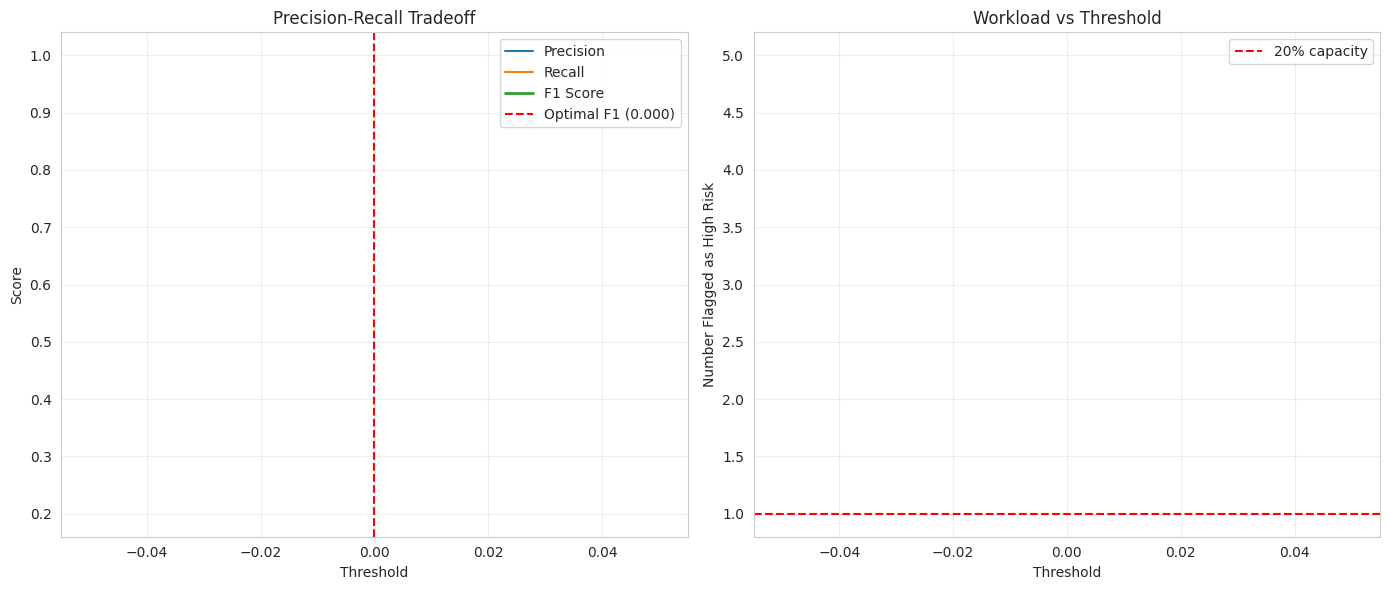


SAVING PREDICTIONS
✓ Predictions saved to: outputs/results/test_predictions.parquet
   Shape: (5, 9)

CREATING RESULTS SUMMARY
✓ Results summary saved to: outputs/results/model_results_summary.json

MODEL TRAINING COMPLETE!

                        FINAL RESULTS SUMMARY                         

📊 Dataset Statistics:
   Training samples:   72
   Calibration samples: 2
   Test samples:       5
   Readmission rate:   20.00%

🔧 Features:
   Structured features: 81
   Embedding features:  768
   Total fused:         849

📈 Model Performance (Test Set):

   Baseline (Structured Only):
      AUROC: 1.0000
      AUPRC: 1.0000
      Brier: 0.2459

   Fused (Structured + Embeddings):
      AUROC: 0.5000 (-0.5000, -50.0%)
      AUPRC: 0.2000 (-0.8000, -80.0%)
      Brier: 0.2000 (calibrated)

   ⚠️  Embeddings show minimal improvement

🎯 Operating Points:
   Optimal F1 Threshold: 0.000
      Precision: 0.200
      Recall:    1.000
      F1:        0.333

   Capacity Threshold (Top 20%): 0.000
 

In [32]:
"""
05_train_models.py (Fixed for Colab)
Train and compare baseline (structured-only) vs fused (structured + embeddings) models
"""

# ============================================================================
# Cell 1: Setup and Install Dependencies
# ============================================================================
import sys
import subprocess

print("Checking and installing dependencies...")
required_packages = ['mlflow', 'lightgbm', 'shap', 'imbalanced-learn']
for package in required_packages:
    try:
        __import__(package.replace('-', '_'))
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import joblib
from datetime import datetime

# ML libraries
import lightgbm as lgb
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    confusion_matrix, classification_report,
    brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression

# Optional MLflow
try:
    import mlflow
    import mlflow.lightgbm
    USE_MLFLOW = True
    print("✓ MLflow enabled")
except ImportError:
    USE_MLFLOW = False
    print("⚠ MLflow not available - skipping experiment tracking")

# SHAP (will try to import later)
SHAP_AVAILABLE = False

import warnings
warnings.filterwarnings('ignore')

print("✓ Setup complete")

# ============================================================================
# Cell 2: Load Configuration and Data
# ============================================================================
base_path = Path('')
processed_dir = base_path / 'data/processed'

# Load config
with open(base_path / 'configs/config.json', 'r') as f:
    config = json.load(f)

# Load structured-only features
print("\nLoading structured-only datasets...")
train_struct = pd.read_parquet(processed_dir / 'train_features.parquet')
calib_struct = pd.read_parquet(processed_dir / 'calibration_features.parquet')
test_struct = pd.read_parquet(processed_dir / 'test_features.parquet')

print(f"✓ Structured features:")
print(f"   Train: {train_struct.shape}")
print(f"   Calib: {calib_struct.shape}")
print(f"   Test:  {test_struct.shape}")

# Load fused features (structured + embeddings)
print("\nLoading fused datasets...")
train_fused = pd.read_parquet(processed_dir / 'train_fused.parquet')
calib_fused = pd.read_parquet(processed_dir / 'calibration_fused.parquet')
test_fused = pd.read_parquet(processed_dir / 'test_fused.parquet')

print(f"✓ Fused features:")
print(f"   Train: {train_fused.shape}")
print(f"   Calib: {calib_fused.shape}")
print(f"   Test:  {test_fused.shape}")

# ============================================================================
# Cell 3: Prepare Features and Labels
# ============================================================================
# Remove categorical columns if they still exist
categorical_cols = ['AGE_GROUP', 'ETHNICITY_CATEGORY', 'LOS_CATEGORY', 'DISCHARGE_SEASON']
for df in [train_struct, calib_struct, test_struct]:
    for col in categorical_cols:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)

# Extract feature names
struct_features = [col for col in train_struct.columns
                   if col not in ['HADM_ID', 'SUBJECT_ID', 'TARGET_READMIT_30']]
fused_features = [col for col in train_fused.columns
                  if col not in ['HADM_ID', 'SUBJECT_ID', 'TARGET_READMIT_30']]
embedding_features = [col for col in fused_features if col.startswith('emb_')]

print(f"\n✓ Feature counts:")
print(f"   Structured features: {len(struct_features)}")
print(f"   Embedding features: {len(embedding_features)}")
print(f"   Total fused features: {len(fused_features)}")

# Prepare structured-only datasets
X_train_struct = train_struct[struct_features].values
y_train = train_struct['TARGET_READMIT_30'].values
X_calib_struct = calib_struct[struct_features].values
y_calib = calib_struct['TARGET_READMIT_30'].values
X_test_struct = test_struct[struct_features].values
y_test = test_struct['TARGET_READMIT_30'].values

# Prepare fused datasets
X_train_fused = train_fused[fused_features].values
X_calib_fused = calib_fused[fused_features].values
X_test_fused = test_fused[fused_features].values

print(f"\n✓ Structured datasets:")
print(f"   Train: {X_train_struct.shape}, Positive: {y_train.mean():.2%}")
print(f"   Calib: {X_calib_struct.shape}, Positive: {y_calib.mean():.2%}")
print(f"   Test:  {X_test_struct.shape}, Positive: {y_test.mean():.2%}")

print(f"\n✓ Fused datasets:")
print(f"   Train: {X_train_fused.shape}")
print(f"   Calib: {X_calib_fused.shape}")
print(f"   Test:  {X_test_fused.shape}")

# ============================================================================
# Cell 4: Data Augmentation (Optional - for small datasets)
# ============================================================================
USE_AUGMENTATION = len(y_train) < 200  # Only if very small dataset

if USE_AUGMENTATION:
    from imblearn.over_sampling import SMOTE
    from collections import Counter

    print("\n" + "="*70)
    print("DATA AUGMENTATION (Small Dataset)")
    print("="*70)

    def apply_combined_augmentation(X, y, target_multiplier=4):
        """SMOTE + Gaussian noise augmentation"""
        print(f"\nOriginal: {X.shape}, {Counter(y)}")

        # Step 1: SMOTE for class balance
        n_minority = min(Counter(y).values())
        k_neighbors = min(5, n_minority - 1) if n_minority > 1 else 1
        smote = SMOTE(sampling_strategy='auto', k_neighbors=k_neighbors, random_state=42)
        X_balanced, y_balanced = smote.fit_resample(X, y)
        print(f"After SMOTE: {X_balanced.shape}, {Counter(y_balanced)}")

        # Step 2: Add noise copies
        X_augmented = [X_balanced]
        y_augmented = [y_balanced]

        for i in range(target_multiplier - 1):
            noise = np.random.normal(0, 0.03, X_balanced.shape) * X_balanced.std(axis=0)
            X_augmented.append(X_balanced + noise)
            y_augmented.append(y_balanced)

        X_final = np.vstack(X_augmented)
        y_final = np.hstack(y_augmented)
        print(f"Final: {X_final.shape}, {Counter(y_final)}")

        return X_final, y_final

    # Apply to both structured and fused
    X_train_struct_aug, y_train_aug = apply_combined_augmentation(
        X_train_struct, y_train, target_multiplier=4
    )
    X_train_fused_aug, _ = apply_combined_augmentation(
        X_train_fused, y_train, target_multiplier=4
    )

    # Use augmented data
    X_train_struct = X_train_struct_aug
    X_train_fused = X_train_fused_aug
    y_train = y_train_aug

    print(f"\n✓ Augmentation complete")
else:
    print(f"\n✓ Skipping augmentation (sufficient training data: {len(y_train)} samples)")

# ============================================================================
# Cell 5: Setup MLflow Tracking (if available)
# ============================================================================
if USE_MLFLOW:
    mlflow.set_tracking_uri(str(base_path / 'mlruns'))
    mlflow.set_experiment('TRANCE_Readmission_Prediction')
    print("\n✓ MLflow tracking initialized")
    print(f"   Tracking URI: {mlflow.get_tracking_uri()}")

# ============================================================================
# Cell 6: Train Baseline Model (Structured Only)
# ============================================================================
print("\n" + "="*70)
print("TRAINING BASELINE MODEL (STRUCTURED ONLY)")
print("="*70)

# Start MLflow run if available
if USE_MLFLOW:
    mlflow.start_run(run_name="Baseline_Structured_Only")

# Model parameters
params_baseline = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 7,
    'max_depth': 3,
    'learning_rate': 0.01,
    'n_estimators': 200,
    'min_child_samples': 10,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

# Log params
if USE_MLFLOW:
    mlflow.log_params(params_baseline)
    mlflow.log_param("n_features", X_train_struct.shape[1])
    mlflow.log_param("n_train", len(X_train_struct))

# Create LightGBM datasets
train_data = lgb.Dataset(X_train_struct, label=y_train)
valid_data = lgb.Dataset(X_calib_struct, label=y_calib, reference=train_data)

# Train model
print("Training baseline model...")
model_baseline = lgb.train(
    params_baseline,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'calib'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print(f"✓ Training complete")
print(f"   Best iteration: {model_baseline.best_iteration}")
print(f"   Best score: {model_baseline.best_score['calib']['auc']:.4f}")

# Predictions
y_pred_baseline_train = model_baseline.predict(X_train_struct)
y_pred_baseline_calib = model_baseline.predict(X_calib_struct)
y_pred_baseline_test = model_baseline.predict(X_test_struct)

# Metrics
train_auc = roc_auc_score(y_train, y_pred_baseline_train)
calib_auc = roc_auc_score(y_calib, y_pred_baseline_calib)
test_auc = roc_auc_score(y_test, y_pred_baseline_test)

train_auprc = average_precision_score(y_train, y_pred_baseline_train)
calib_auprc = average_precision_score(y_calib, y_pred_baseline_calib)
test_auprc = average_precision_score(y_test, y_pred_baseline_test)

if USE_MLFLOW:
    mlflow.log_metric("train_auc", train_auc)
    mlflow.log_metric("calib_auc", calib_auc)
    mlflow.log_metric("test_auc", test_auc)
    mlflow.log_metric("train_auprc", train_auprc)
    mlflow.log_metric("calib_auprc", calib_auprc)
    mlflow.log_metric("test_auprc", test_auprc)

print(f"\nBaseline Model Performance:")
print(f"  Train AUROC: {train_auc:.4f} | AUPRC: {train_auprc:.4f}")
print(f"  Calib AUROC: {calib_auc:.4f} | AUPRC: {calib_auprc:.4f}")
print(f"  Test  AUROC: {test_auc:.4f} | AUPRC: {test_auprc:.4f}")

# Save model
model_path = base_path / 'outputs/models/baseline_model.txt'
model_path.parent.mkdir(parents=True, exist_ok=True)
model_baseline.save_model(str(model_path))
if USE_MLFLOW:
    mlflow.log_artifact(str(model_path))
print(f"\n✓ Model saved to: {model_path}")

if USE_MLFLOW:
    mlflow.end_run()

# ============================================================================
# Cell 7: Train Fused Model (Structured + Embeddings)
# ============================================================================
print("\n" + "="*70)
print("TRAINING FUSED MODEL (STRUCTURED + EMBEDDINGS)")
print("="*70)

if USE_MLFLOW:
    mlflow.start_run(run_name="Fused_Structured_Embeddings")
    mlflow.log_param("model_type", "LightGBM")
    mlflow.log_param("features", "structured_and_embeddings")
    mlflow.log_param("n_features", len(fused_features))
    mlflow.log_param("n_embedding_dims", len(embedding_features))
    mlflow.log_param("n_train", len(X_train_fused))
    for key, value in params_baseline.items():
        mlflow.log_param(f"lgbm_{key}", value)

# Model parameters (same as baseline for fair comparison)
params_fused = params_baseline.copy()

# Create datasets
train_data = lgb.Dataset(X_train_fused, label=y_train)
valid_data = lgb.Dataset(X_calib_fused, label=y_calib, reference=train_data)

# Train model
print("Training fused model...")
model_fused = lgb.train(
    params_fused,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print(f"✓ Training complete")
print(f"   Best iteration: {model_fused.best_iteration}")
print(f"   Best score: {model_fused.best_score['valid']['auc']:.4f}")

# Make predictions
y_pred_fused_train = model_fused.predict(X_train_fused)
y_pred_fused_calib = model_fused.predict(X_calib_fused)
y_pred_fused_test = model_fused.predict(X_test_fused)

# Evaluate
train_auc_f = roc_auc_score(y_train, y_pred_fused_train)
calib_auc_f = roc_auc_score(y_calib, y_pred_fused_calib)
test_auc_f = roc_auc_score(y_test, y_pred_fused_test)

train_auprc_f = average_precision_score(y_train, y_pred_fused_train)
calib_auprc_f = average_precision_score(y_calib, y_pred_fused_calib)
test_auprc_f = average_precision_score(y_test, y_pred_fused_test)

# Log metrics
if USE_MLFLOW:
    mlflow.log_metric("train_auc", train_auc_f)
    mlflow.log_metric("calib_auc", calib_auc_f)
    mlflow.log_metric("test_auc", test_auc_f)
    mlflow.log_metric("train_auprc", train_auprc_f)
    mlflow.log_metric("calib_auprc", calib_auprc_f)
    mlflow.log_metric("test_auprc", test_auprc_f)

print(f"\nFused Model Performance:")
print(f"  Train AUROC: {train_auc_f:.4f} | AUPRC: {train_auprc_f:.4f}")
print(f"  Calib AUROC: {calib_auc_f:.4f} | AUPRC: {calib_auprc_f:.4f}")
print(f"  Test  AUROC: {test_auc_f:.4f} | AUPRC: {test_auprc_f:.4f}")

# Save model
model_path = base_path / 'outputs/models/fused_model.txt'
model_fused.save_model(str(model_path))
if USE_MLFLOW:
    mlflow.log_artifact(str(model_path))
    mlflow.end_run()

print(f"\n✓ Model saved to: {model_path}")

# ============================================================================
# Cell 8: Model Comparison
# ============================================================================
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

# Calculate improvements
auc_improvement = test_auc_f - test_auc
auprc_improvement = test_auprc_f - test_auprc

print("\nTest Set Performance Comparison:")
print("-" * 70)
print(f"{'Metric':<20} {'Baseline':<12} {'Fused':<12} {'Improvement':<12}")
print("-" * 70)
print(f"{'AUROC':<20} {test_auc:<12.4f} {test_auc_f:<12.4f} {auc_improvement:+.4f} ({auc_improvement/test_auc*100:+.2f}%)")
print(f"{'AUPRC':<20} {test_auprc:<12.4f} {test_auprc_f:<12.4f} {auprc_improvement:+.4f} ({auprc_improvement/test_auprc*100:+.2f}%)")
print("-" * 70)

if auc_improvement > 0:
    print(f"\n✅ Embeddings provide {auc_improvement:.4f} AUROC improvement!")
else:
    print(f"\n⚠️  Embeddings don't improve performance significantly")

# ============================================================================
# Cell 9: ROC and PR Curves
# ============================================================================
print("\n" + "="*70)
print("GENERATING PERFORMANCE CURVES")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_baseline_test)
fpr_fused, tpr_fused, _ = roc_curve(y_test, y_pred_fused_test)

axes[0].plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUROC={test_auc:.3f})', linewidth=2)
axes[0].plot(fpr_fused, tpr_fused, label=f'Fused (AUROC={test_auc_f:.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.3)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - Test Set')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
precision_baseline, recall_baseline, _ = precision_recall_curve(y_test, y_pred_baseline_test)
precision_fused, recall_fused, _ = precision_recall_curve(y_test, y_pred_fused_test)

axes[1].plot(recall_baseline, precision_baseline, label=f'Baseline (AUPRC={test_auprc:.3f})', linewidth=2)
axes[1].plot(recall_fused, precision_fused, label=f'Fused (AUPRC={test_auprc_f:.3f})', linewidth=2)
axes[1].axhline(y=y_test.mean(), color='k', linestyle='--', label='Baseline Rate', alpha=0.3)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve - Test Set')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
fig_path = base_path / 'outputs/figures/model_performance_curves.png'
fig_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Performance curves saved to: {fig_path}")
plt.show()

# ============================================================================
# Cell 10: Feature Importance Analysis
# ============================================================================
print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Get feature importance
importance_baseline = model_baseline.feature_importance(importance_type='gain')
importance_fused = model_fused.feature_importance(importance_type='gain')

# Create dataframes
feat_imp_baseline = pd.DataFrame({
    'feature': struct_features,
    'importance': importance_baseline
}).sort_values('importance', ascending=False)

feat_imp_fused = pd.DataFrame({
    'feature': fused_features,
    'importance': importance_fused
}).sort_values('importance', ascending=False)

# Separate structured vs embedding importance in fused model
feat_imp_fused['type'] = feat_imp_fused['feature'].apply(
    lambda x: 'Embedding' if x.startswith('emb_') else 'Structured'
)

# Calculate total importance by type
total_importance = feat_imp_fused.groupby('type')['importance'].sum()
print("\nImportance Distribution in Fused Model:")
print(f"  Structured features: {total_importance.get('Structured', 0):.0f} ({total_importance.get('Structured', 0)/feat_imp_fused['importance'].sum()*100:.1f}%)")
print(f"  Embedding features:  {total_importance.get('Embedding', 0):.0f} ({total_importance.get('Embedding', 0)/feat_imp_fused['importance'].sum()*100:.1f}%)")

# Top features
print("\nTop 15 Features (Baseline Model):")
print(feat_imp_baseline.head(15).to_string(index=False))

print("\nTop 15 Features (Fused Model):")
print(feat_imp_fused.head(15).to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Baseline top features
top_n = 20
feat_imp_baseline.head(top_n).plot.barh(x='feature', y='importance', ax=axes[0], legend=False)
axes[0].set_title('Top 20 Features - Baseline Model')
axes[0].set_xlabel('Importance (Gain)')
axes[0].invert_yaxis()

# Fused top features with color coding
top_fused = feat_imp_fused.head(top_n)
colors = ['steelblue' if t == 'Structured' else 'orange' for t in top_fused['type']]
axes[1].barh(range(len(top_fused)), top_fused['importance'], color=colors)
axes[1].set_yticks(range(len(top_fused)))
axes[1].set_yticklabels(top_fused['feature'])
axes[1].set_title('Top 20 Features - Fused Model')
axes[1].set_xlabel('Importance (Gain)')
axes[1].invert_yaxis()
axes[1].legend(['Structured', 'Embedding'], loc='lower right')

plt.tight_layout()
plt.savefig(base_path / 'outputs/figures/feature_importance.png', dpi=300, bbox_inches='tight')
print("\n✓ Feature importance plots saved")
plt.show()

# ============================================================================
# Cell 11: SHAP Analysis (Fused Model) - Optional
# ============================================================================
print("\n" + "="*70)
print("GENERATING SHAP VALUES")
print("="*70)

try:
    import shap
    SHAP_AVAILABLE = True

    # Sample for SHAP (use subset for speed)
    n_shap_samples = min(500, len(X_test_fused))

    # Create DataFrame for sampling
    test_fused_df = pd.DataFrame(X_test_fused, columns=fused_features)
    X_shap = test_fused_df.sample(n=n_shap_samples, random_state=42)

    print(f"Computing SHAP values for {n_shap_samples} samples...")

    # Create SHAP explainer
    explainer = shap.TreeExplainer(model_fused)
    shap_values = explainer.shap_values(X_shap)

    # If binary classification, shap_values might be a list
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Positive class

    print("✓ SHAP values computed")

    # Save SHAP values
    shap_data = {
        'shap_values': shap_values,
        'data': X_shap.values,
        'feature_names': X_shap.columns.tolist(),
        'expected_value': explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value
    }

    joblib.dump(shap_data, base_path / 'outputs/models/shap_values.pkl')
    print("✓ SHAP values saved")

    # SHAP summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_shap, max_display=20, show=False)
    plt.tight_layout()
    plt.savefig(base_path / 'outputs/figures/shap_summary.png', dpi=300, bbox_inches='tight')
    print("✓ SHAP summary plot saved")
    plt.show()

except ImportError:
    print("⚠ SHAP not available - skipping interpretability analysis")
    print("  Install with: pip install shap")
except Exception as e:
    print(f"⚠ SHAP analysis failed: {e}")
    print("  Continuing without SHAP...")

# ============================================================================
# Cell 12: Probability Calibration
# ============================================================================
print("\n" + "="*70)
print("PROBABILITY CALIBRATION")
print("="*70)

# Fit calibrator on calibration set
print("Fitting isotonic regression calibrator...")
calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(y_pred_fused_calib, y_calib)

# Calibrate test predictions
y_pred_calibrated = calibrator.predict(y_pred_fused_test)

# Evaluate calibration
brier_uncalibrated = brier_score_loss(y_test, y_pred_fused_test)
brier_calibrated = brier_score_loss(y_test, y_pred_calibrated)

print(f"\nBrier Score:")
print(f"  Uncalibrated: {brier_uncalibrated:.4f}")
print(f"  Calibrated:   {brier_calibrated:.4f}")
print(f"  Improvement:  {brier_uncalibrated - brier_calibrated:.4f}")

# Calibration curve
fraction_of_positives_uncal, mean_predicted_value_uncal = calibration_curve(
    y_test, y_pred_fused_test, n_bins=10, strategy='uniform'
)
fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(
    y_test, y_pred_calibrated, n_bins=10, strategy='uniform'
)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Reliability diagram
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
axes[0].plot(mean_predicted_value_uncal, fraction_of_positives_uncal,
             'o-', label=f'Uncalibrated (Brier={brier_uncalibrated:.3f})')
axes[0].plot(mean_predicted_value_cal, fraction_of_positives_cal,
             's-', label=f'Calibrated (Brier={brier_calibrated:.3f})')
axes[0].set_xlabel('Mean Predicted Probability')
axes[0].set_ylabel('Observed Frequency')
axes[0].set_title('Reliability Diagram')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Distribution of predictions
axes[1].hist(y_pred_fused_test, bins=30, alpha=0.5, label='Uncalibrated', edgecolor='black')
axes[1].hist(y_pred_calibrated, bins=30, alpha=0.5, label='Calibrated', edgecolor='black')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Predictions')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(base_path / 'outputs/figures/calibration_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Calibration plots saved")
plt.show()

# Save calibrator
joblib.dump(calibrator, base_path / 'outputs/models/calibrator.pkl')
print("✓ Calibrator saved")

# ============================================================================
# Cell 13: Operating Point Analysis
# ============================================================================
print("\n" + "="*70)
print("OPERATING POINT ANALYSIS")
print("="*70)

# Calculate precision, recall, F1 at different thresholds
thresholds = np.linspace(0, 1, 100)
metrics_at_threshold = []

for thresh in thresholds:
    y_pred_binary = (y_pred_calibrated >= thresh).astype(int)

    if y_pred_binary.sum() == 0:
        continue

    tp = ((y_pred_binary == 1) & (y_test == 1)).sum()
    fp = ((y_pred_binary == 1) & (y_test == 0)).sum()
    fn = ((y_pred_binary == 0) & (y_test == 1)).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    metrics_at_threshold.append({
        'threshold': thresh,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'n_predicted_positive': y_pred_binary.sum()
    })

metrics_df = pd.DataFrame(metrics_at_threshold)

# Find optimal thresholds
optimal_f1_idx = metrics_df['f1'].idxmax()
optimal_f1_threshold = metrics_df.loc[optimal_f1_idx, 'threshold']

print(f"Optimal F1 Threshold: {optimal_f1_threshold:.3f}")
print(f"  Precision: {metrics_df.loc[optimal_f1_idx, 'precision']:.3f}")
print(f"  Recall:    {metrics_df.loc[optimal_f1_idx, 'recall']:.3f}")
print(f"  F1 Score:  {metrics_df.loc[optimal_f1_idx, 'f1']:.3f}")

# Capacity-based threshold (e.g., top 20% patients)
capacity_percentile = 80  # Top 20%
capacity_threshold = np.percentile(y_pred_calibrated, capacity_percentile)

capacity_mask = y_pred_calibrated >= capacity_threshold
capacity_precision = y_test[capacity_mask].mean()
capacity_recall = y_test[capacity_mask].sum() / y_test.sum()

print(f"\nCapacity-Based Threshold (top {100-capacity_percentile}%): {capacity_threshold:.3f}")
print(f"  Precision: {capacity_precision:.3f}")
print(f"  Recall:    {capacity_recall:.3f}")
print(f"  N flagged: {capacity_mask.sum()} ({capacity_mask.mean()*100:.1f}%)")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Precision-Recall tradeoff
axes[0].plot(metrics_df['threshold'], metrics_df['precision'], label='Precision')
axes[0].plot(metrics_df['threshold'], metrics_df['recall'], label='Recall')
axes[0].plot(metrics_df['threshold'], metrics_df['f1'], label='F1 Score', linewidth=2)
axes[0].axvline(optimal_f1_threshold, color='red', linestyle='--',
                label=f'Optimal F1 ({optimal_f1_threshold:.3f})')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Precision-Recall Tradeoff')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Number flagged vs threshold
axes[1].plot(metrics_df['threshold'], metrics_df['n_predicted_positive'])
axes[1].axhline(len(y_test) * 0.2, color='red', linestyle='--', label='20% capacity')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Number Flagged as High Risk')
axes[1].set_title('Workload vs Threshold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(base_path / 'outputs/figures/operating_point_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Operating point plots saved")
plt.show()

# ============================================================================
# Cell 14: Save All Predictions
# ============================================================================
print("\n" + "="*70)
print("SAVING PREDICTIONS")
print("="*70)

# Create predictions dataframe
predictions_df = pd.DataFrame({
    'HADM_ID': test_fused['HADM_ID'].values,
    'SUBJECT_ID': test_fused['SUBJECT_ID'].values,
    'true_label': y_test,
    'pred_prob_baseline': y_pred_baseline_test,
    'pred_prob_fused_raw': y_pred_fused_test,
    'pred_prob_fused_calibrated': y_pred_calibrated,
    'pred_binary_f1_optimal': (y_pred_calibrated >= optimal_f1_threshold).astype(int),
    'pred_binary_capacity': (y_pred_calibrated >= capacity_threshold).astype(int),
    'risk_score': (y_pred_calibrated * 100).round(1)  # Convert to 0-100 scale
})

# Save
predictions_path = base_path / 'outputs/results/test_predictions.parquet'
predictions_path.parent.mkdir(parents=True, exist_ok=True)
predictions_df.to_parquet(predictions_path, index=False)

print(f"✓ Predictions saved to: {predictions_path}")
print(f"   Shape: {predictions_df.shape}")

# Also save threshold configuration
threshold_config = {
    'optimal_f1_threshold': float(optimal_f1_threshold),
    'capacity_threshold': float(capacity_threshold),
    'capacity_percentile': capacity_percentile
}
with open(base_path / 'outputs/results/thresholds.json', 'w') as f:
    json.dump(threshold_config, f, indent=2)

# ============================================================================
# Cell 15: Create Results Summary
# ============================================================================
print("\n" + "="*70)
print("CREATING RESULTS SUMMARY")
print("="*70)

results_summary = {
    'experiment_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'data': {
        'n_train': int(len(y_train)),
        'n_calib': int(len(y_calib)),
        'n_test': int(len(y_test)),
        'readmission_rate': float(y_test.mean())
    },
    'features': {
        'n_structured': len(struct_features),
        'n_embedding': len(embedding_features),
        'n_total_fused': len(fused_features)
    },
    'baseline_model': {
        'features': 'structured_only',
        'test_auroc': float(test_auc),
        'test_auprc': float(test_auprc),
        'brier_score': float(brier_score_loss(y_test, y_pred_baseline_test))
    },
    'fused_model': {
        'features': 'structured_and_embeddings',
        'test_auroc': float(test_auc_f),
        'test_auprc': float(test_auprc_f),
        'brier_score_uncalibrated': float(brier_uncalibrated),
        'brier_score_calibrated': float(brier_calibrated)
    },
    'improvements': {
        'auroc_gain': float(auc_improvement),
        'auroc_gain_pct': float(auc_improvement / test_auc * 100),
        'auprc_gain': float(auprc_improvement),
        'auprc_gain_pct': float(auprc_improvement / test_auprc * 100)
    },
    'embedding_contribution': {
        'importance_pct': float(total_importance.get('Embedding', 0) / feat_imp_fused['importance'].sum() * 100)
    },
    'operating_points': {
        'optimal_f1_threshold': float(optimal_f1_threshold),
        'optimal_f1_precision': float(metrics_df.loc[optimal_f1_idx, 'precision']),
        'optimal_f1_recall': float(metrics_df.loc[optimal_f1_idx, 'recall']),
        'capacity_threshold': float(capacity_threshold),
        'capacity_precision': float(capacity_precision),
        'capacity_recall': float(capacity_recall)
    }
}

# Save summary
summary_path = base_path / 'outputs/results/model_results_summary.json'
with open(summary_path, 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"✓ Results summary saved to: {summary_path}")

# ============================================================================
# Cell 16: Final Summary Report
# ============================================================================
print("\n" + "="*70)
print("MODEL TRAINING COMPLETE!")
print("="*70)

print(f"\n{'='*70}")
print(f"{'FINAL RESULTS SUMMARY':^70}")
print(f"{'='*70}")

print(f"\n📊 Dataset Statistics:")
print(f"   Training samples:   {len(y_train):,}")
print(f"   Calibration samples: {len(y_calib):,}")
print(f"   Test samples:       {len(y_test):,}")
print(f"   Readmission rate:   {y_test.mean():.2%}")

print(f"\n🔧 Features:")
print(f"   Structured features: {len(struct_features)}")
print(f"   Embedding features:  {len(embedding_features)}")
print(f"   Total fused:         {len(fused_features)}")

print(f"\n📈 Model Performance (Test Set):")
print(f"\n   Baseline (Structured Only):")
print(f"      AUROC: {test_auc:.4f}")
print(f"      AUPRC: {test_auprc:.4f}")
print(f"      Brier: {brier_score_loss(y_test, y_pred_baseline_test):.4f}")

print(f"\n   Fused (Structured + Embeddings):")
print(f"      AUROC: {test_auc_f:.4f} ({auc_improvement:+.4f}, {auc_improvement/test_auc*100:+.1f}%)")
print(f"      AUPRC: {test_auprc_f:.4f} ({auprc_improvement:+.4f}, {auprc_improvement/test_auprc*100:+.1f}%)")
print(f"      Brier: {brier_calibrated:.4f} (calibrated)")

if auc_improvement > 0:
    print(f"\n   ✅ Embeddings improve AUROC by {auc_improvement:.4f} ({auc_improvement/test_auc*100:.1f}%)")
else:
    print(f"\n   ⚠️  Embeddings show minimal improvement")

print(f"\n🎯 Operating Points:")
print(f"   Optimal F1 Threshold: {optimal_f1_threshold:.3f}")
print(f"      Precision: {metrics_df.loc[optimal_f1_idx, 'precision']:.3f}")
print(f"      Recall:    {metrics_df.loc[optimal_f1_idx, 'recall']:.3f}")
print(f"      F1:        {metrics_df.loc[optimal_f1_idx, 'f1']:.3f}")

print(f"\n   Capacity Threshold (Top 20%): {capacity_threshold:.3f}")
print(f"      Precision: {capacity_precision:.3f}")
print(f"      Recall:    {capacity_recall:.3f}")
print(f"      N flagged: {capacity_mask.sum()}")

print(f"\n💾 Saved Outputs:")
print(f"   Models:")
print(f"      • outputs/models/baseline_model.txt")
print(f"      • outputs/models/fused_model.txt")
print(f"      • outputs/models/calibrator.pkl")
if SHAP_AVAILABLE:
    print(f"      • outputs/models/shap_values.pkl")

print(f"\n   Results:")
print(f"      • outputs/results/test_predictions.parquet")
print(f"      • outputs/results/model_results_summary.json")
print(f"      • outputs/results/thresholds.json")

print(f"\n   Figures:")
print(f"      • outputs/figures/model_performance_curves.png")
print(f"      • outputs/figures/feature_importance.png")
print(f"      • outputs/figures/calibration_analysis.png")
print(f"      • outputs/figures/operating_point_analysis.png")
if SHAP_AVAILABLE:
    print(f"      • outputs/figures/shap_summary.png")

print(f"\n📝 Next Steps:")
print(f"   1. Review model performance and feature importance")
print(f"   2. Build Streamlit dashboard (06_build_dashboard.py)")
print(f"   3. Implement volume forecasting")
print(f"   4. Create patient risk interface")
print(f"   5. Set up model monitoring and retraining pipeline")

print(f"\n{'='*70}\n")